In [25]:
#from Thesis.util.csv_visualisation import *
from Thesis.util.hdf5_visualisation import *
import os
import h5py
import pandas as pd
from ema_workbench.em_framework.optimization import epsilon_nondominated, to_problem
from Thesis.util.model_definitions import get_justice_model
import matplotlib.pyplot as plt


**Quick final metric value inspection**

In [159]:
metric_name = "epsilon_progress" 
seeds = [12345, 23403, 39349, 60930, 93489]            
problem_name = "JUSTICE"    
cores = 48                   
moeas = ["eps_nsgaii",'borg','generational_borg']               

group_name = "convergence" if metric_name == "epsilon_progress" else "metrics"

for moea in moeas:
    final_values = []
    for seed in seeds:
        filepath = f"./results/{problem_name}/{cores}cores/{moea}/seed{seed}/results_{problem_name}_{moea}_{cores}cores_seed{seed}.h5"
        
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            continue

        with h5py.File(filepath, "r") as f:
            if group_name not in f:
                print(f"Group '{group_name}' not found in file: {filepath}")
                continue
            
            group = f[group_name]
            if metric_name not in group:
                print(f"Metric '{metric_name}' not found in group '{group_name}' in file: {filepath}")
                continue
            
            metric_data = group[metric_name][()]
            if len(metric_data) == 0:
                print(f"No data in metric '{metric_name}' for seed {seed}")
                continue

            final_value = metric_data[-1]
            final_values.append((seed, final_value))

    if final_values:
        print(f"\nFinal values for {moea} metric '{metric_name}':")
        for seed, value in final_values:
            print(f"  Seed {seed}: {value:.6f}")
        
        values_only = [val for _, val in final_values]
        print(f"\nAverage final value: {np.mean(values_only):.6f}")
    else:
        print("No valid data found for any seed.")


Final values for eps_nsgaii metric 'epsilon_progress':
  Seed 12345: 1900.000000
  Seed 23403: 1963.000000
  Seed 39349: 1949.000000
  Seed 60930: 1938.000000
  Seed 93489: 1864.000000

Average final value: 1922.800000

Final values for borg metric 'epsilon_progress':
  Seed 12345: 7022.000000
  Seed 23403: 7372.000000
  Seed 39349: 7517.000000
  Seed 60930: 7598.000000
  Seed 93489: 7569.000000

Average final value: 7415.600000

Final values for generational_borg metric 'epsilon_progress':
  Seed 12345: 1760.000000
  Seed 23403: 1626.000000
  Seed 39349: 1699.000000
  Seed 60930: 1629.000000
  Seed 93489: 1629.000000

Average final value: 1668.600000


**Visual performance metric analysis**

In [62]:
problem_names = ['DTLZ2','DTLZ3','JUSTICE']
moeas = ['eps_nsgaii','borg', 'generational_borg']
core_count = [16,32,48]
seeds = 5
metric_names = ['hypervolume', 'generational_distance', 'epsilon_indicator', 
               'archive_size', 'spread', 'spacing', 'time_efficiency', 'epsilon_progress']

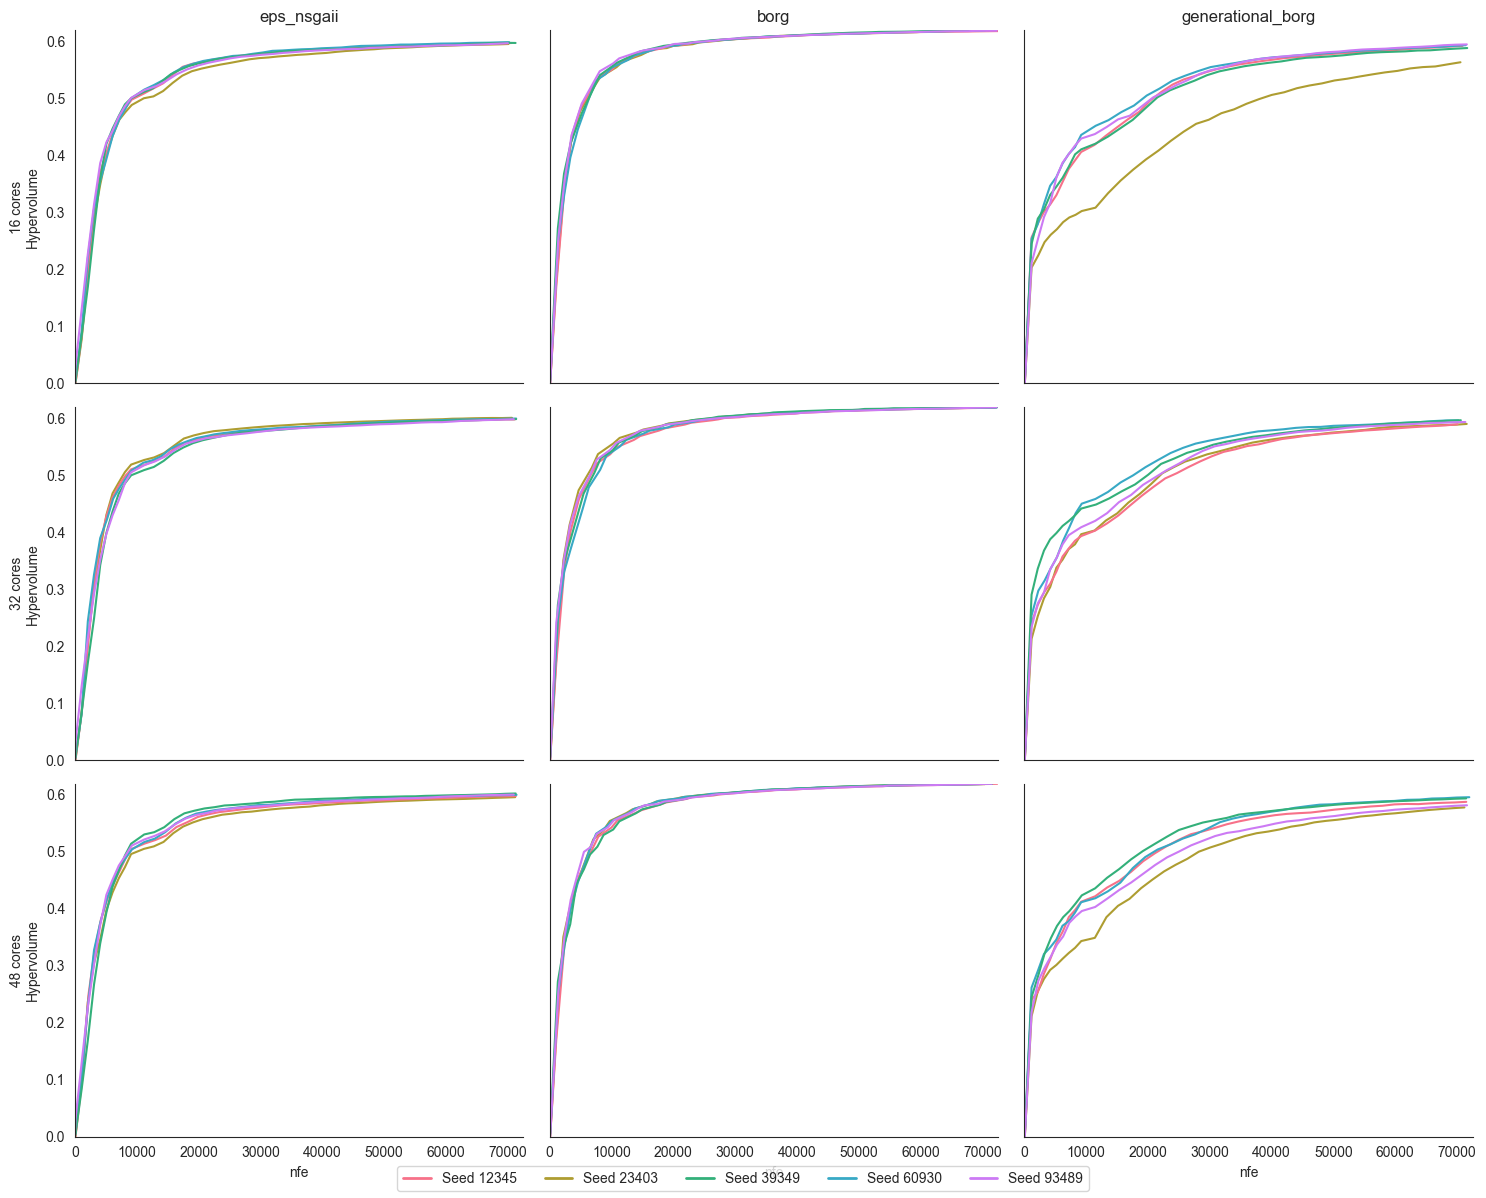

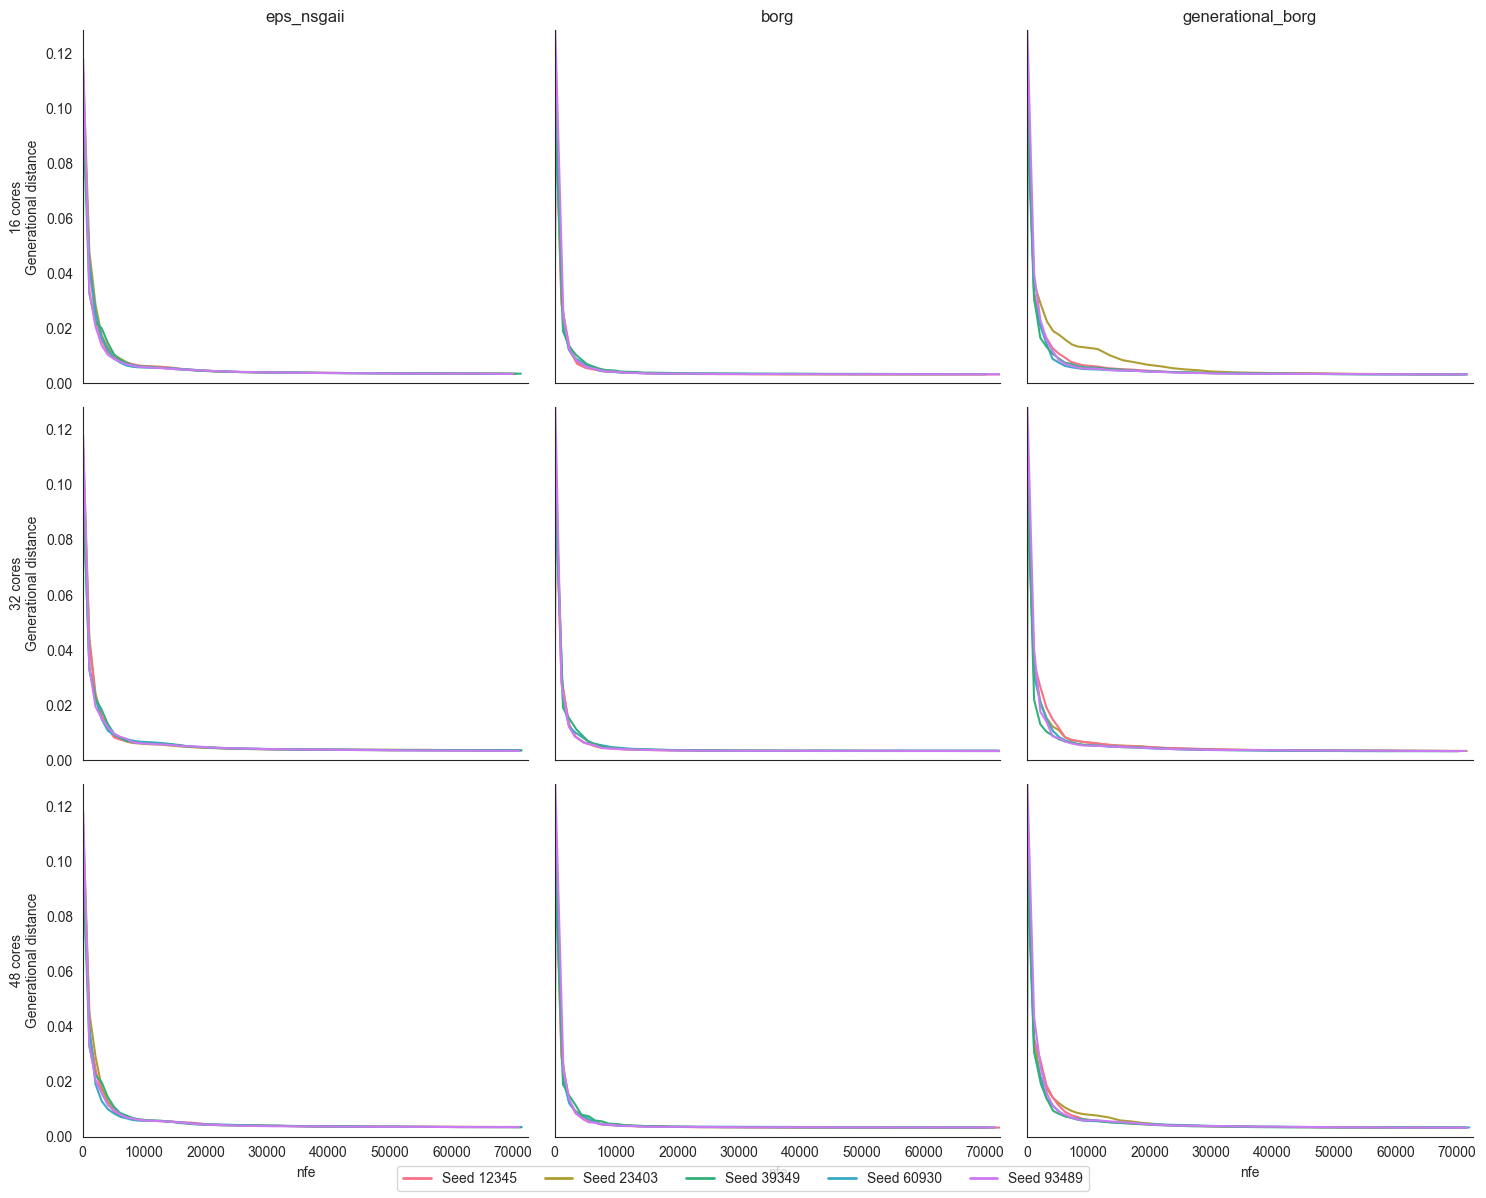

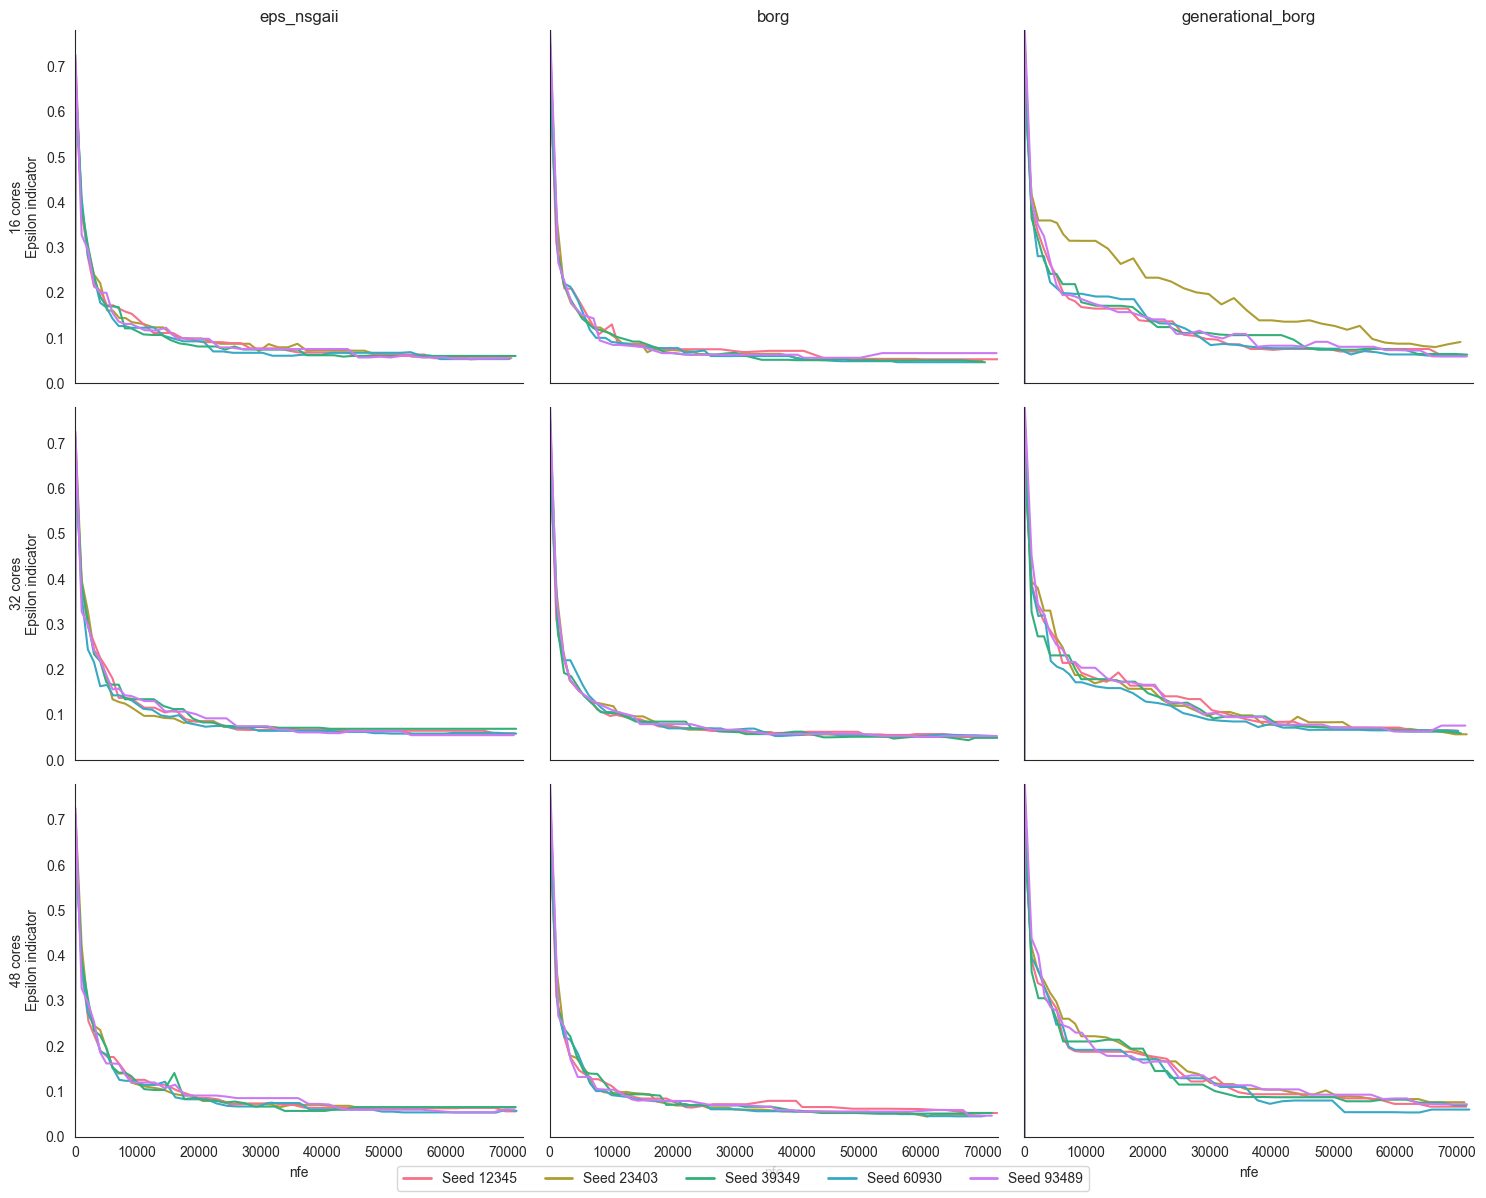

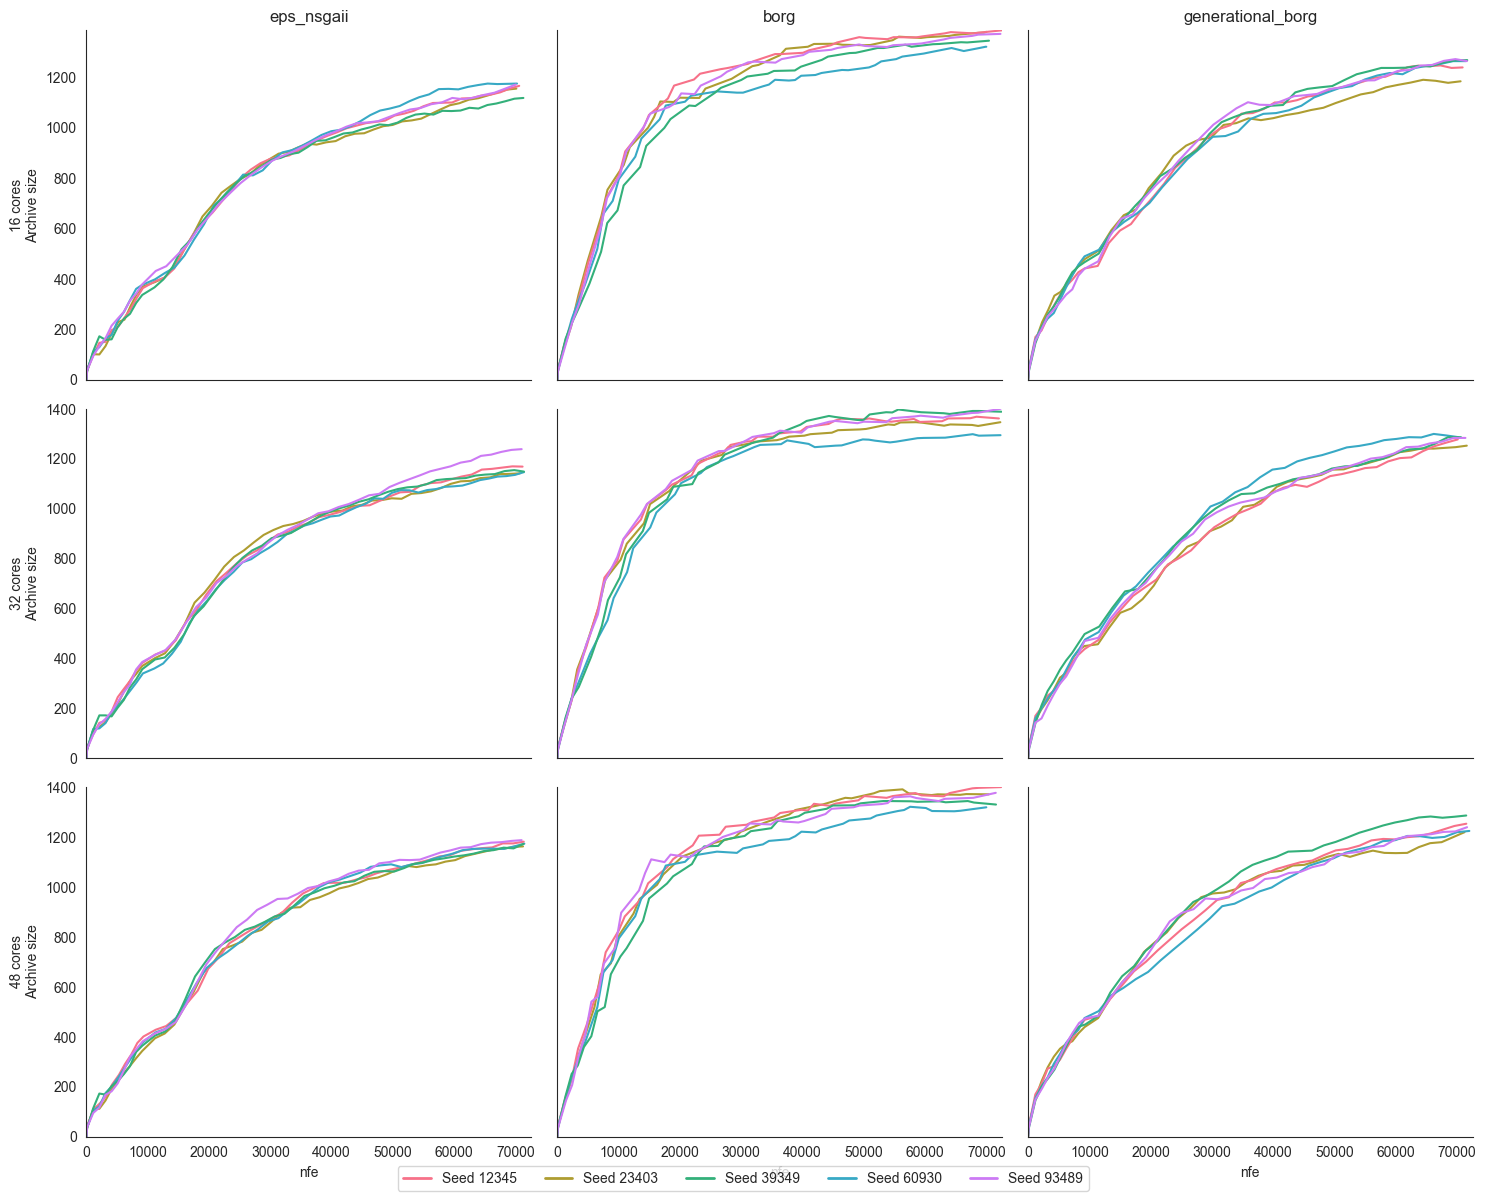

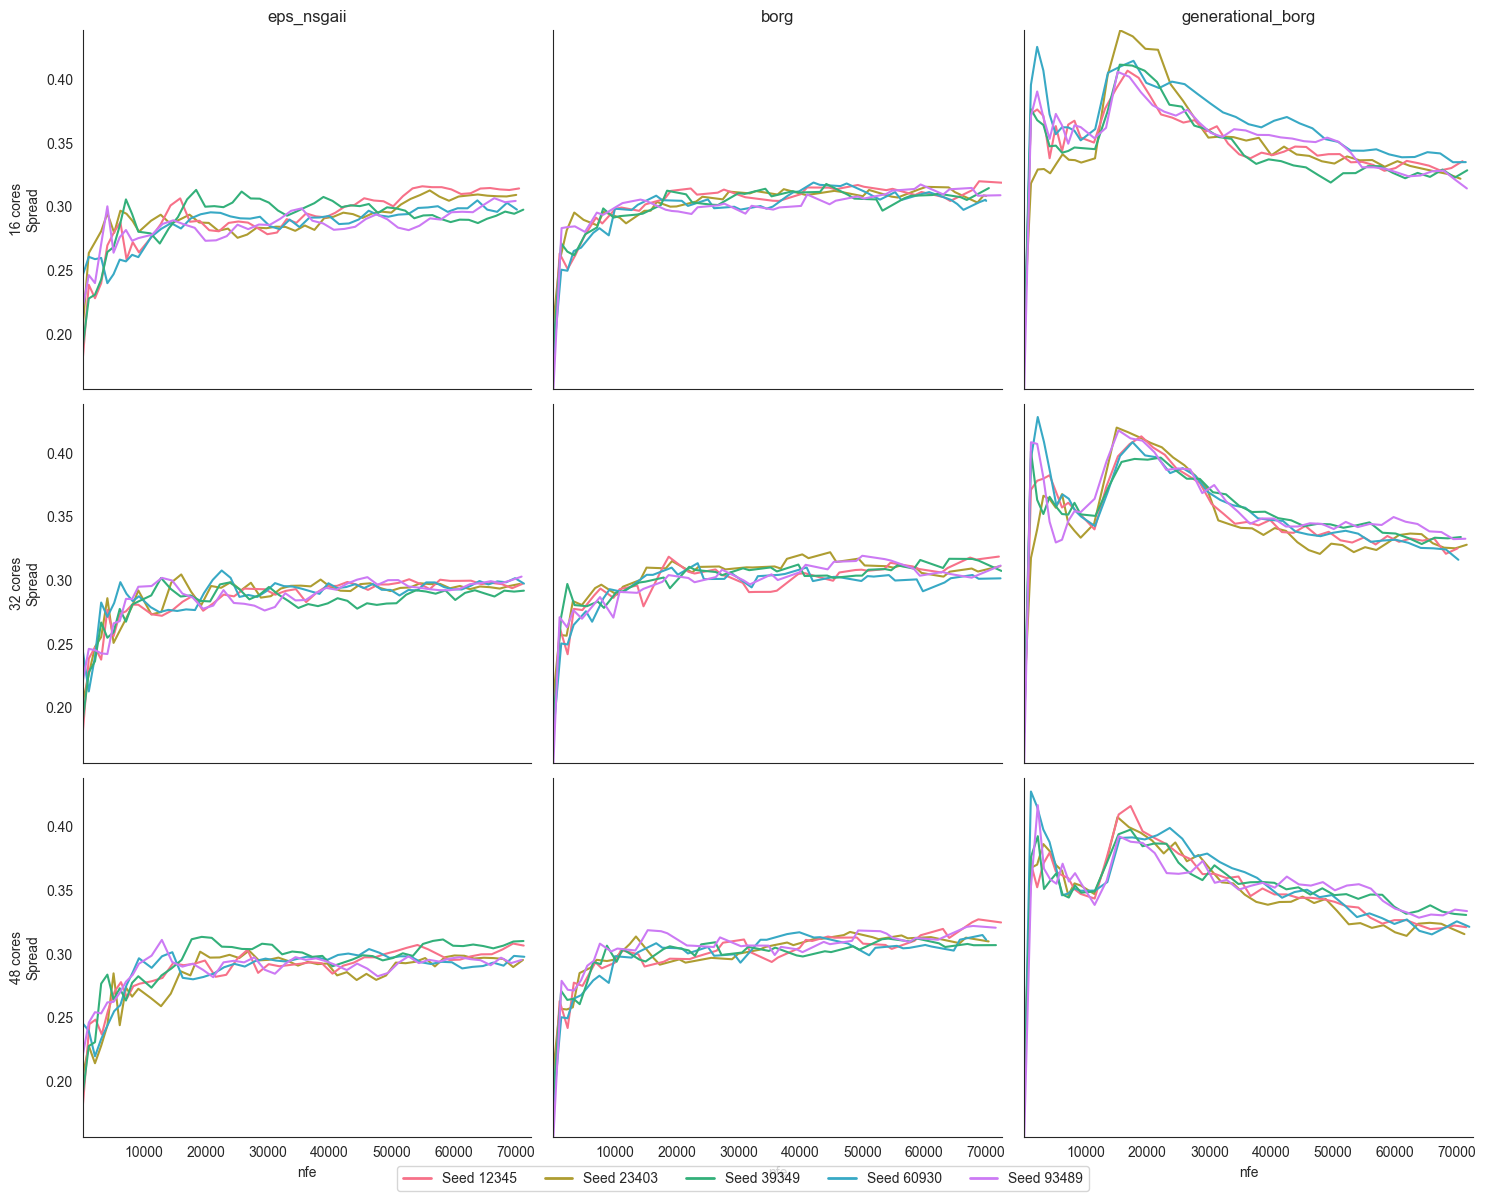

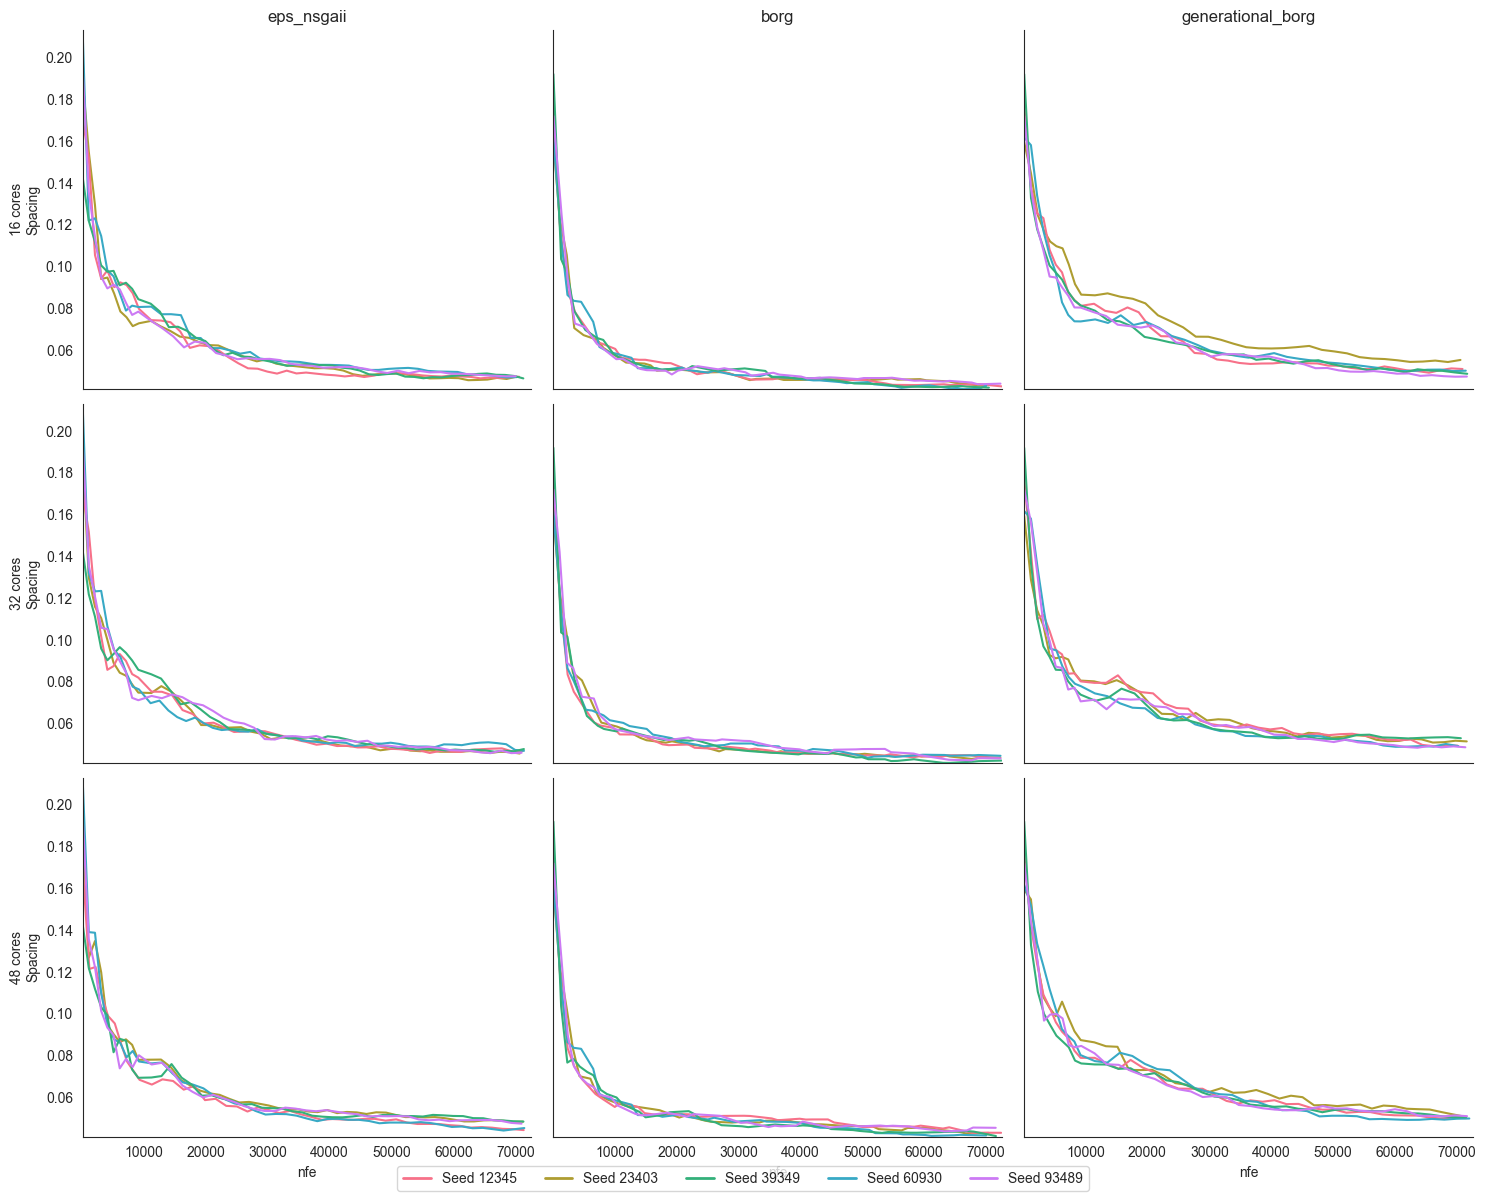

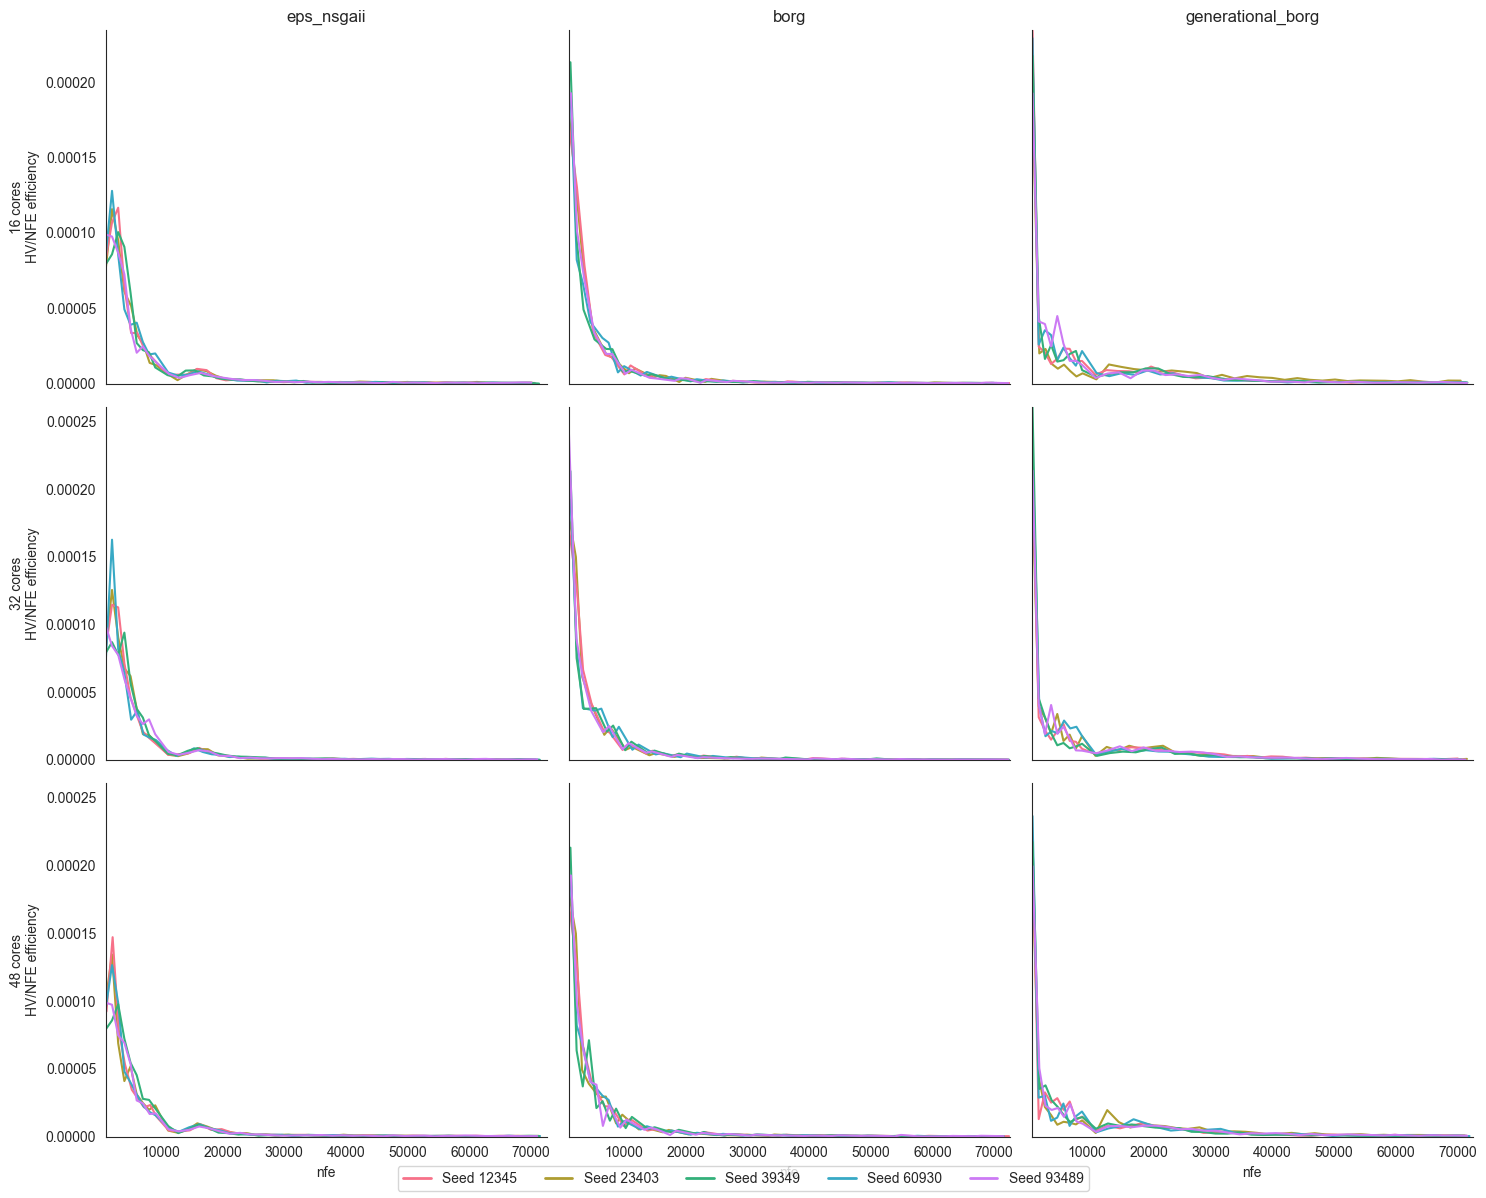

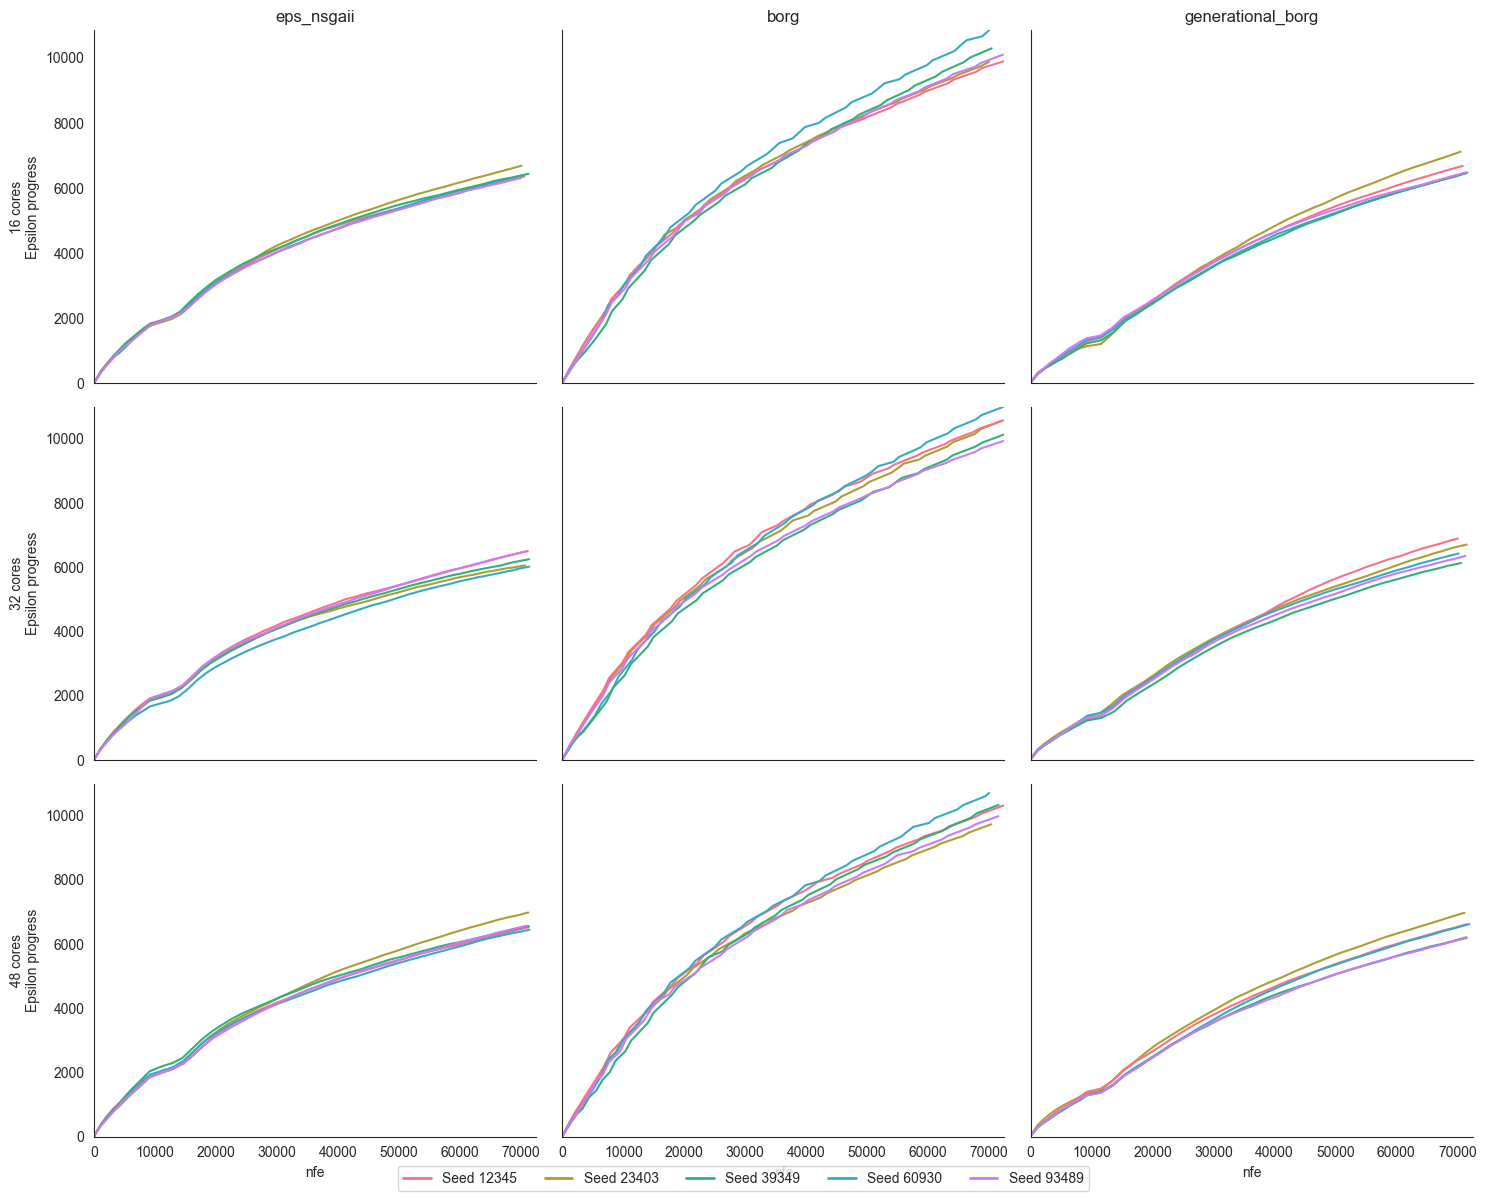

In [63]:
plot_metrics_by_cores(problem_names[0], moeas, core_count, metric_names)

/Users/wouter/Documents/Studie/Engineering and Policy Analysis/Scriptie/Code/MOEA_convergence/Thesis/util/hdf5_visualisation.py:151: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)


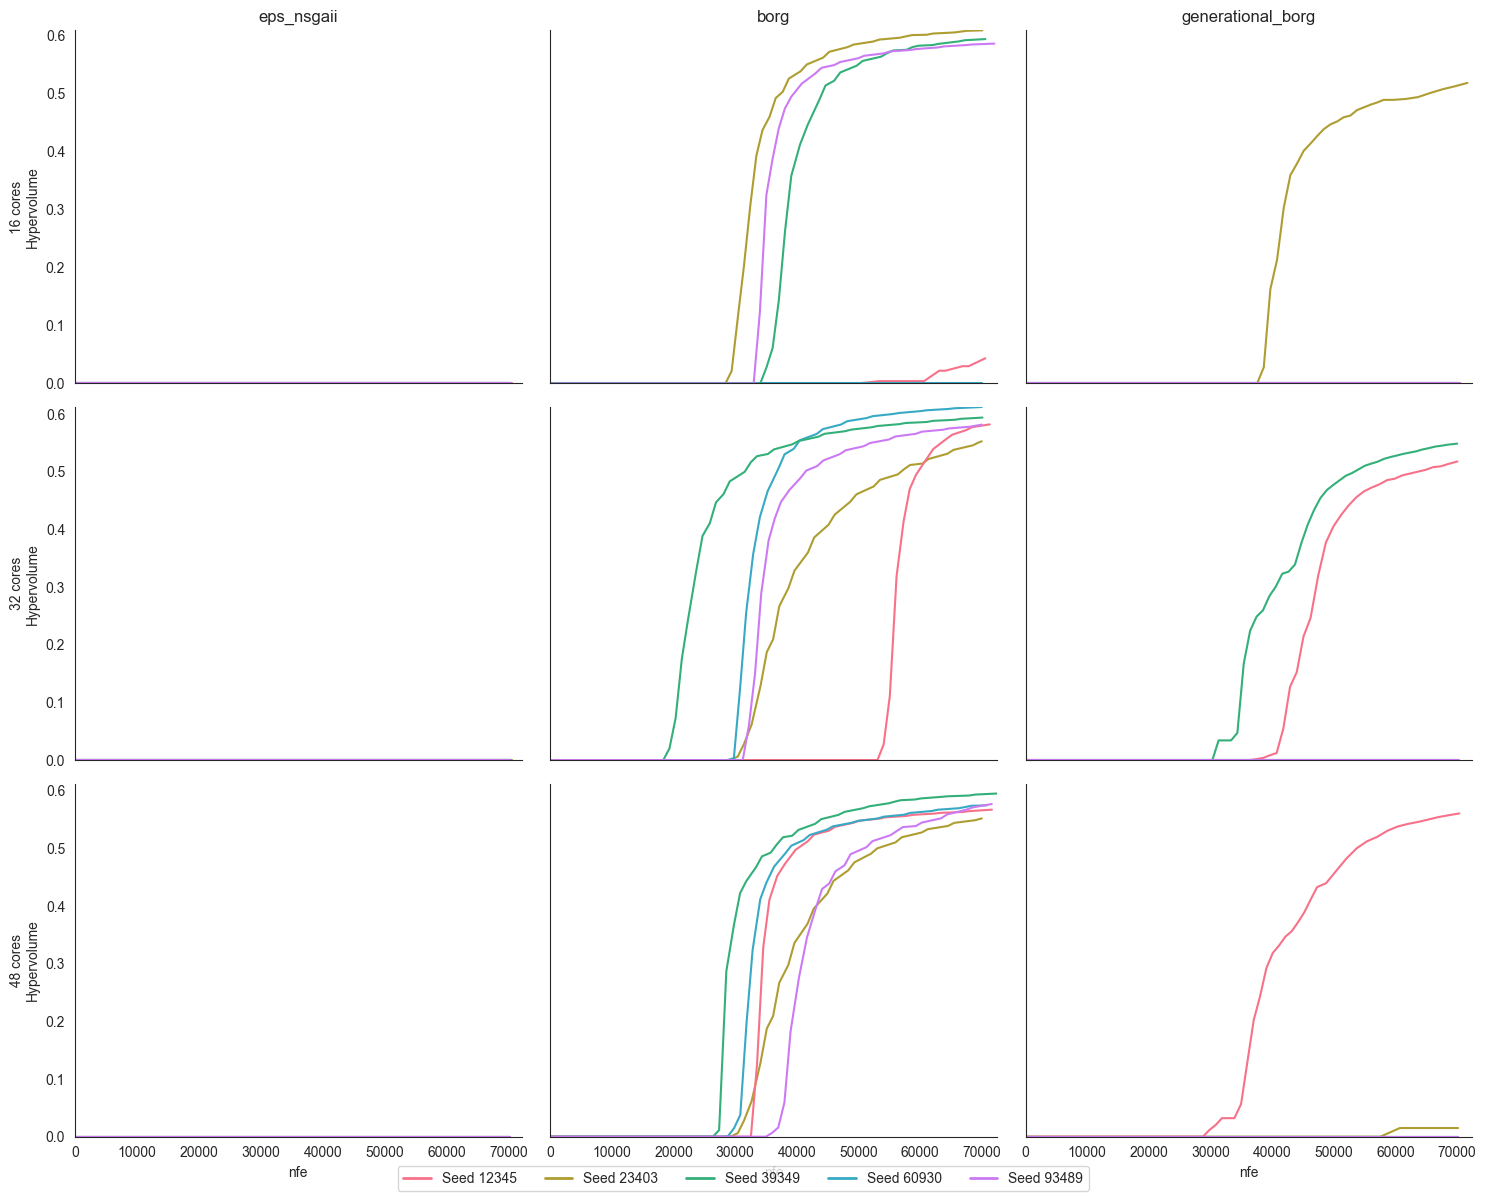

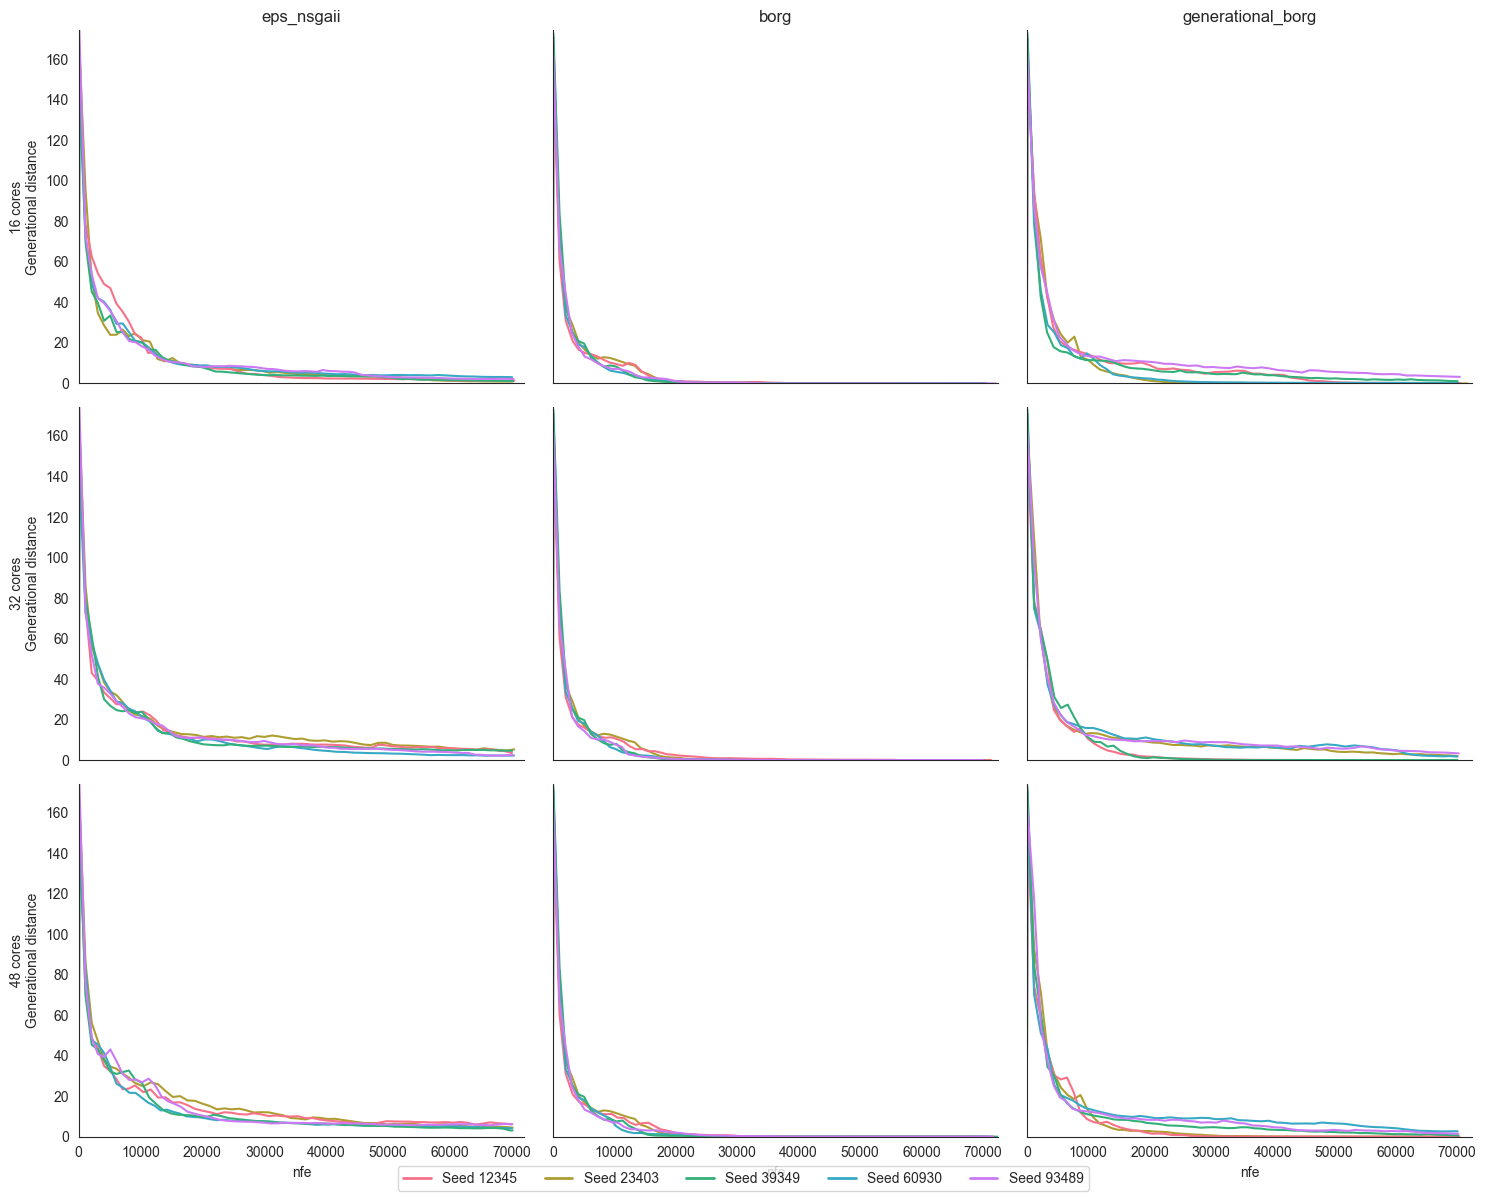

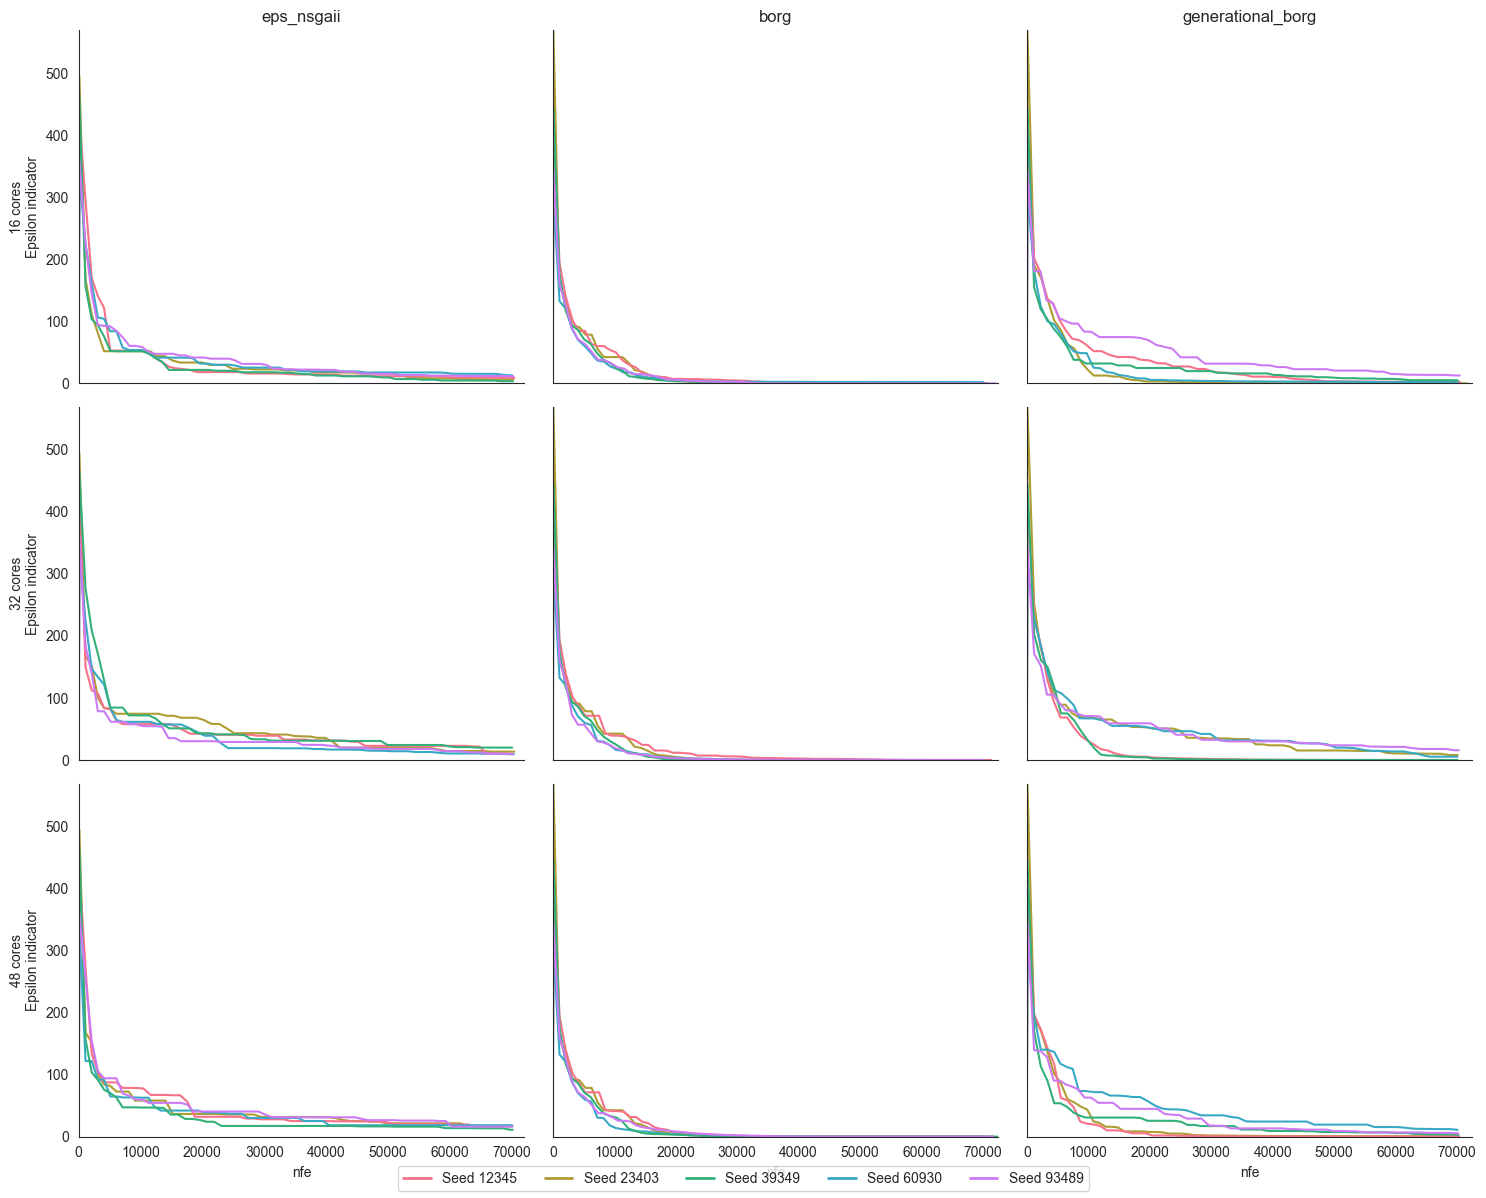

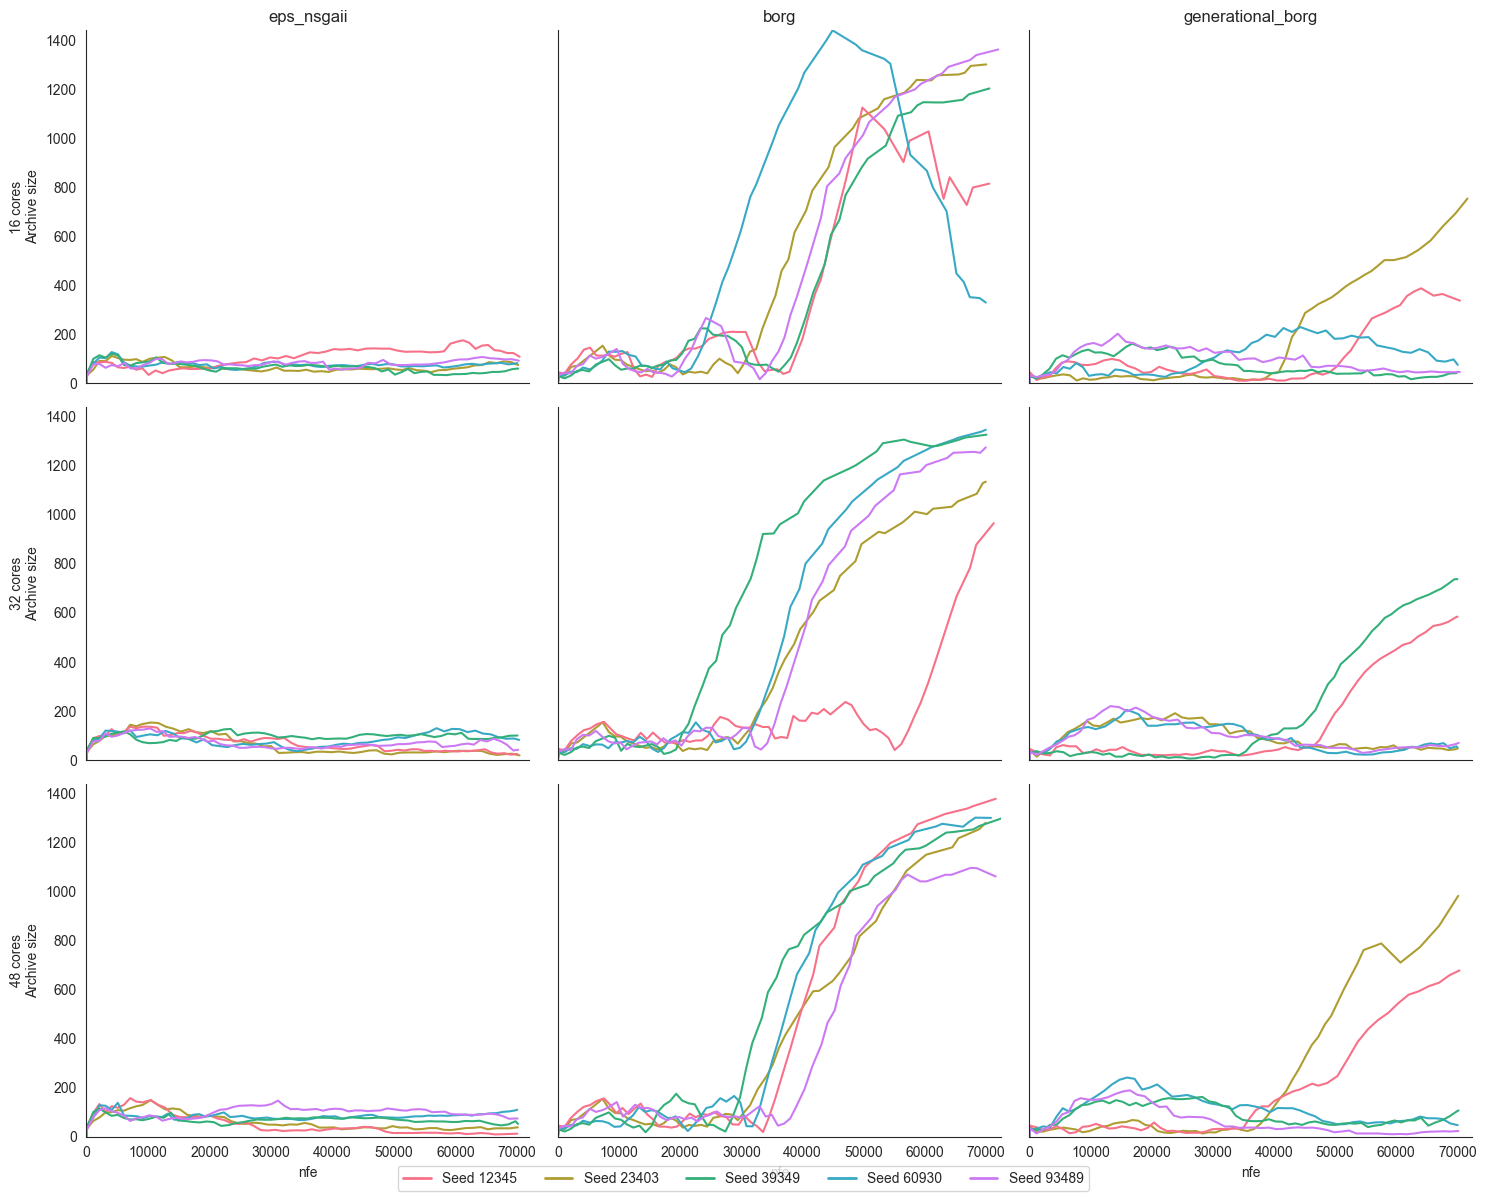

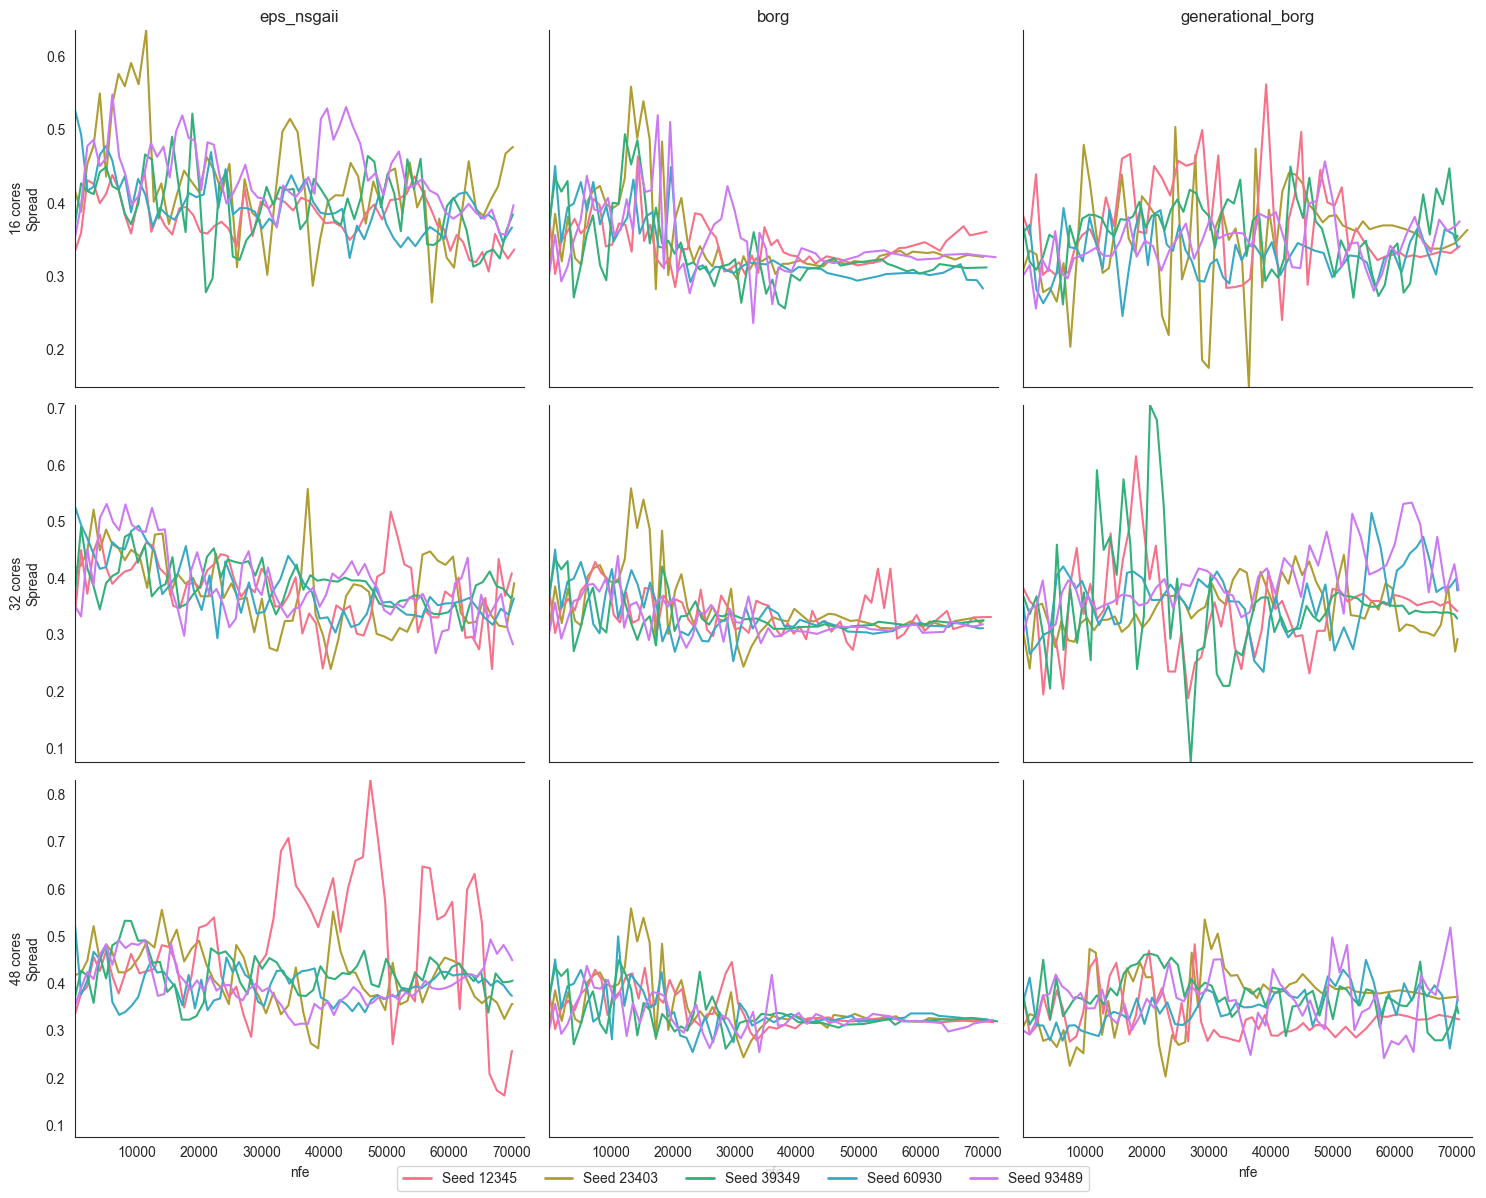

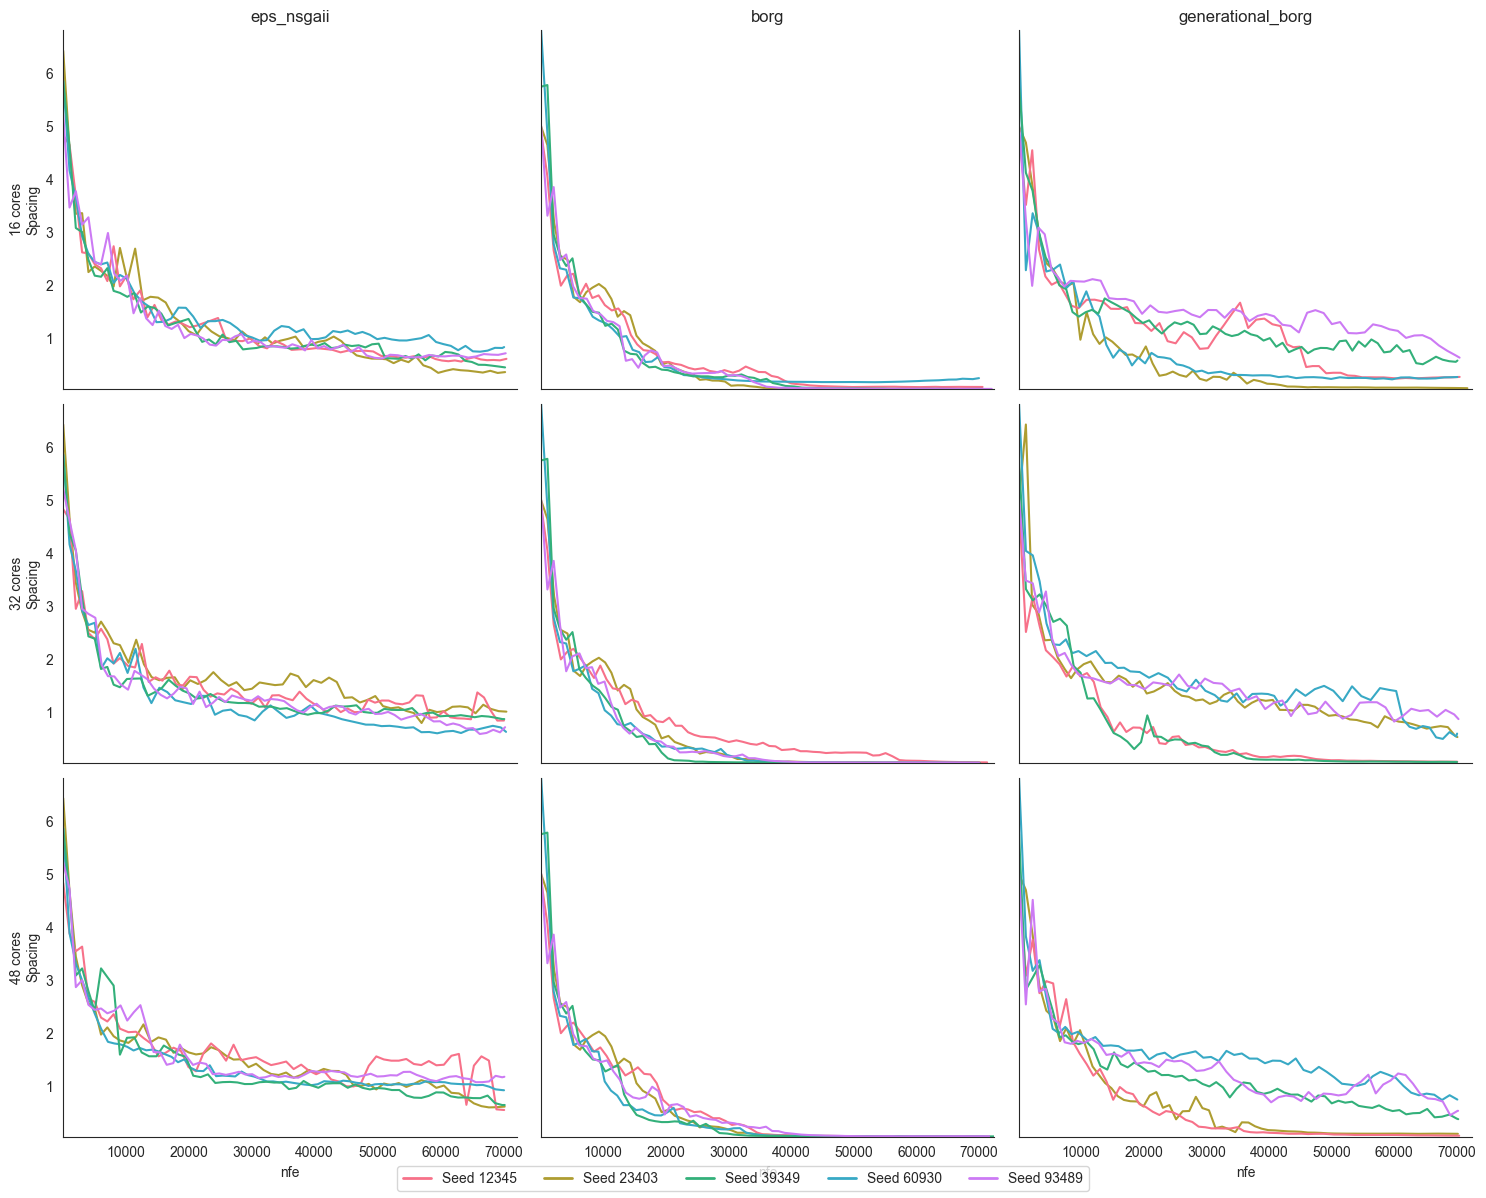

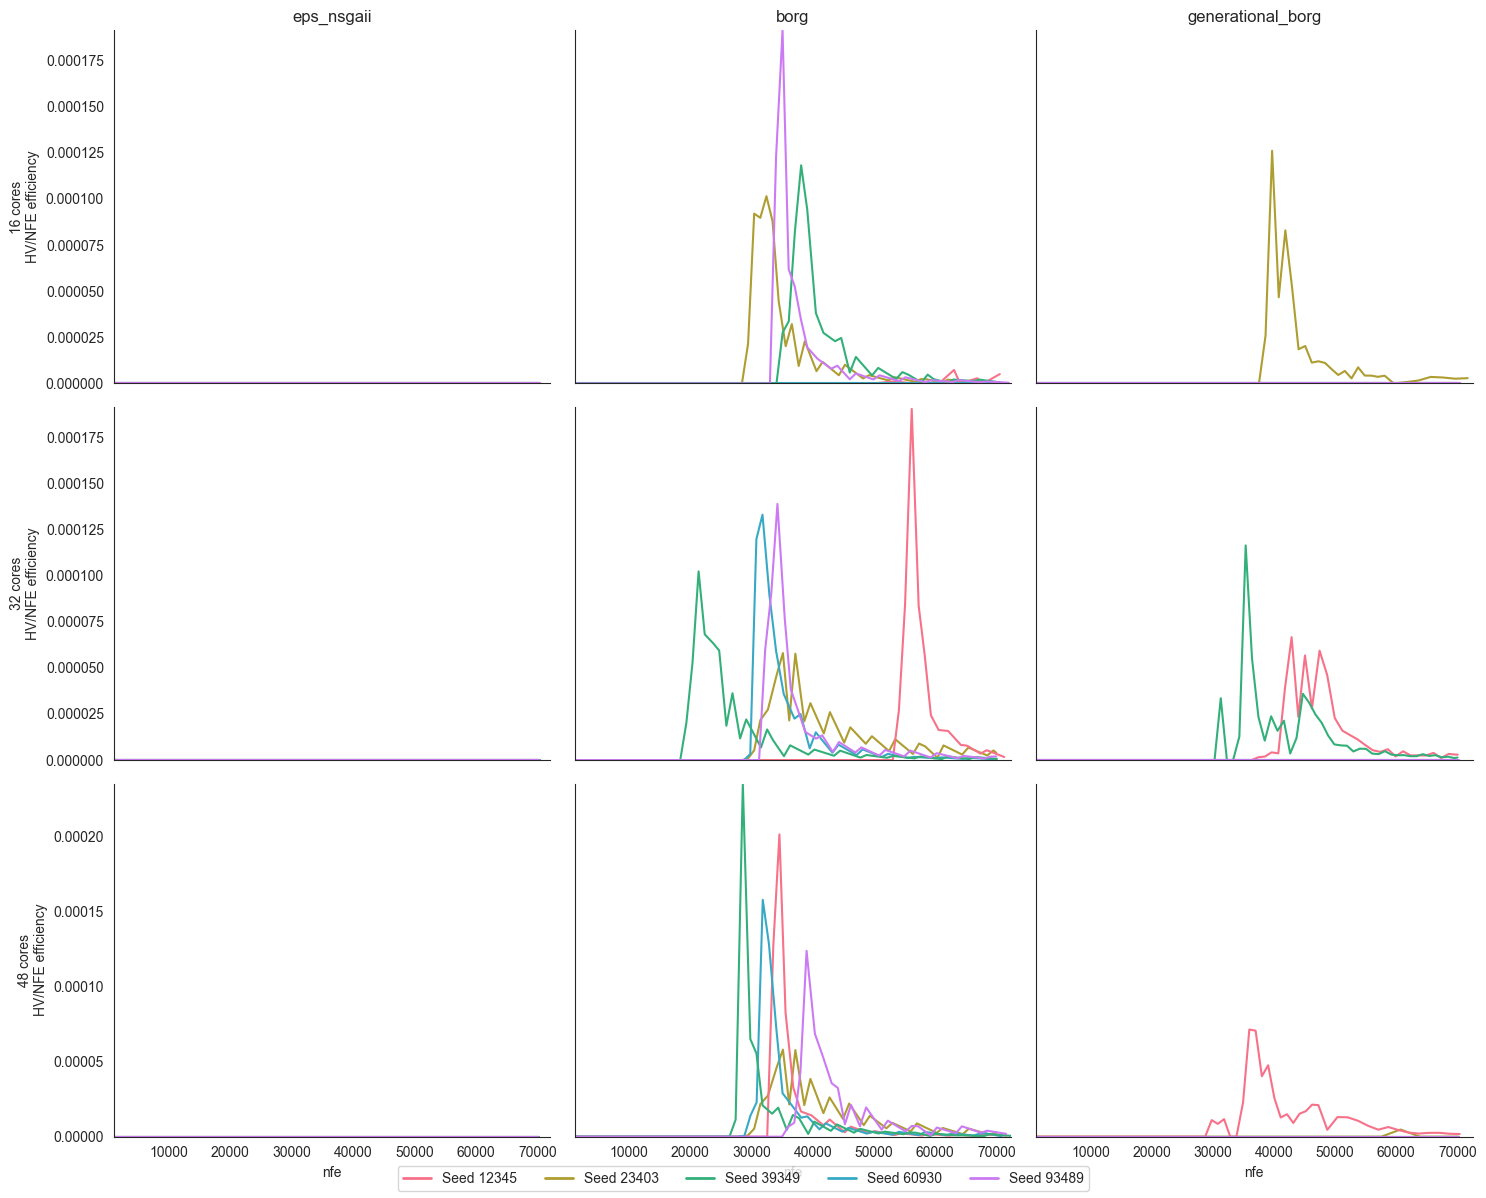

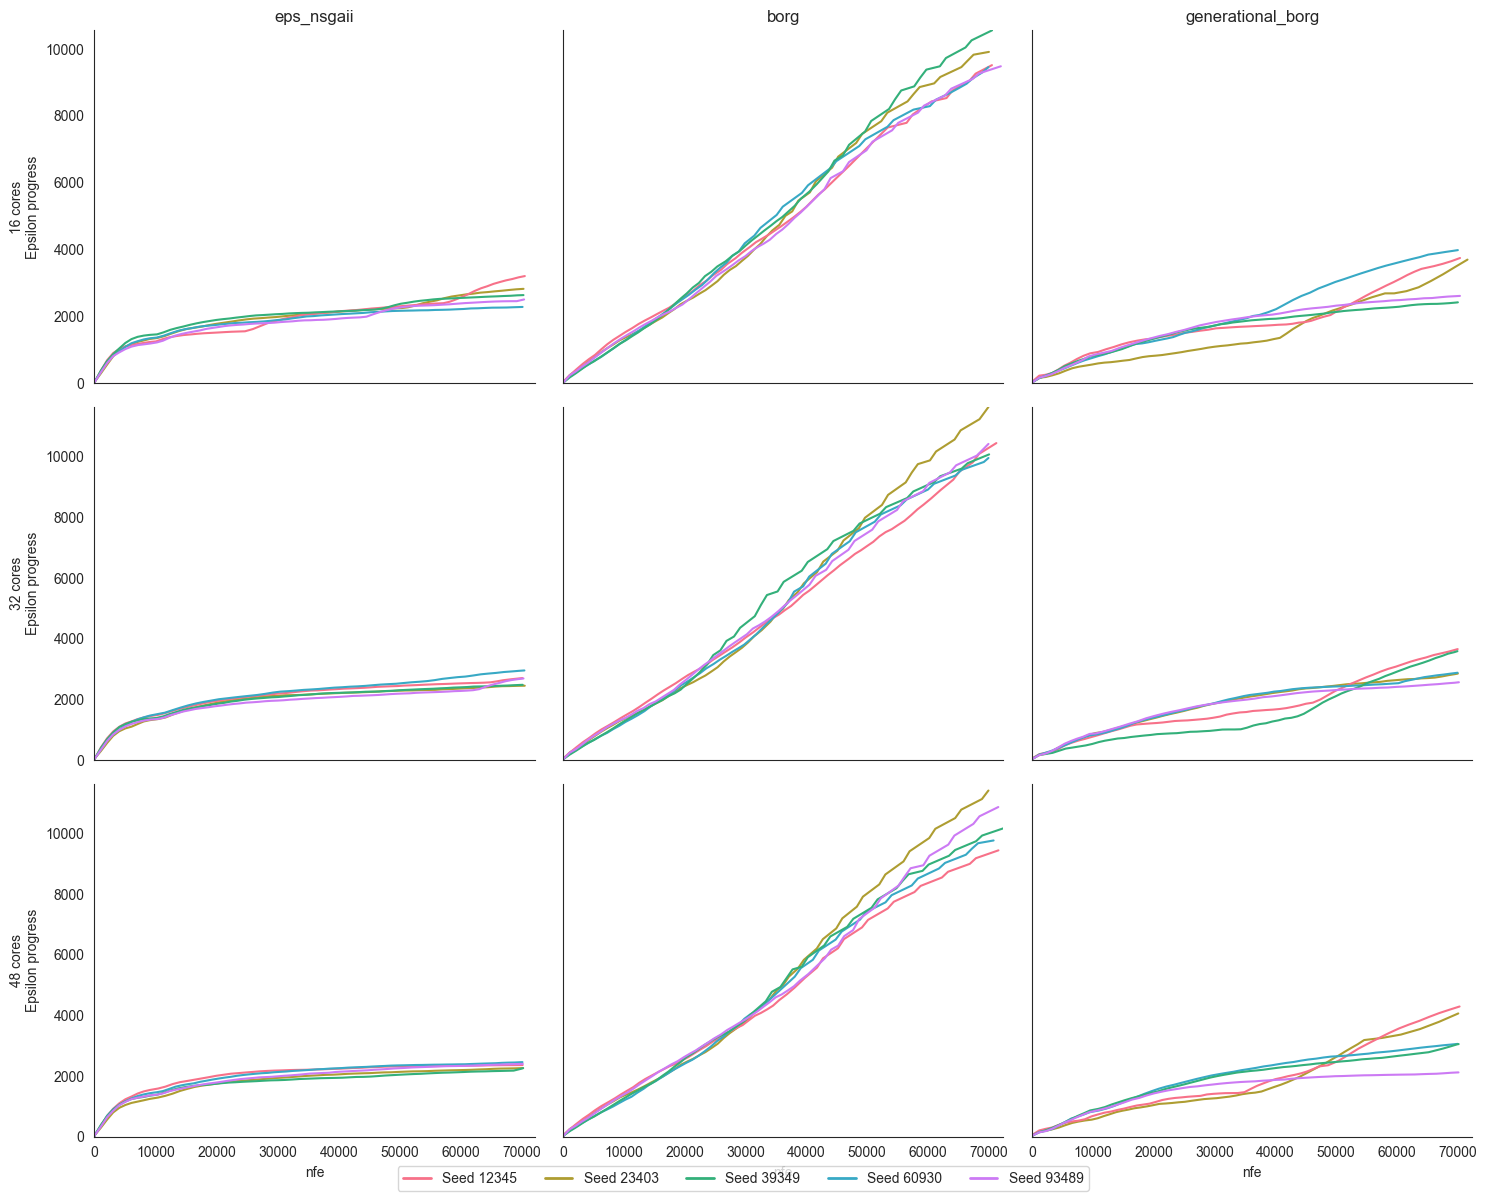

In [73]:
plot_metrics_by_cores(problem_names[1], moeas, core_count, metric_names)

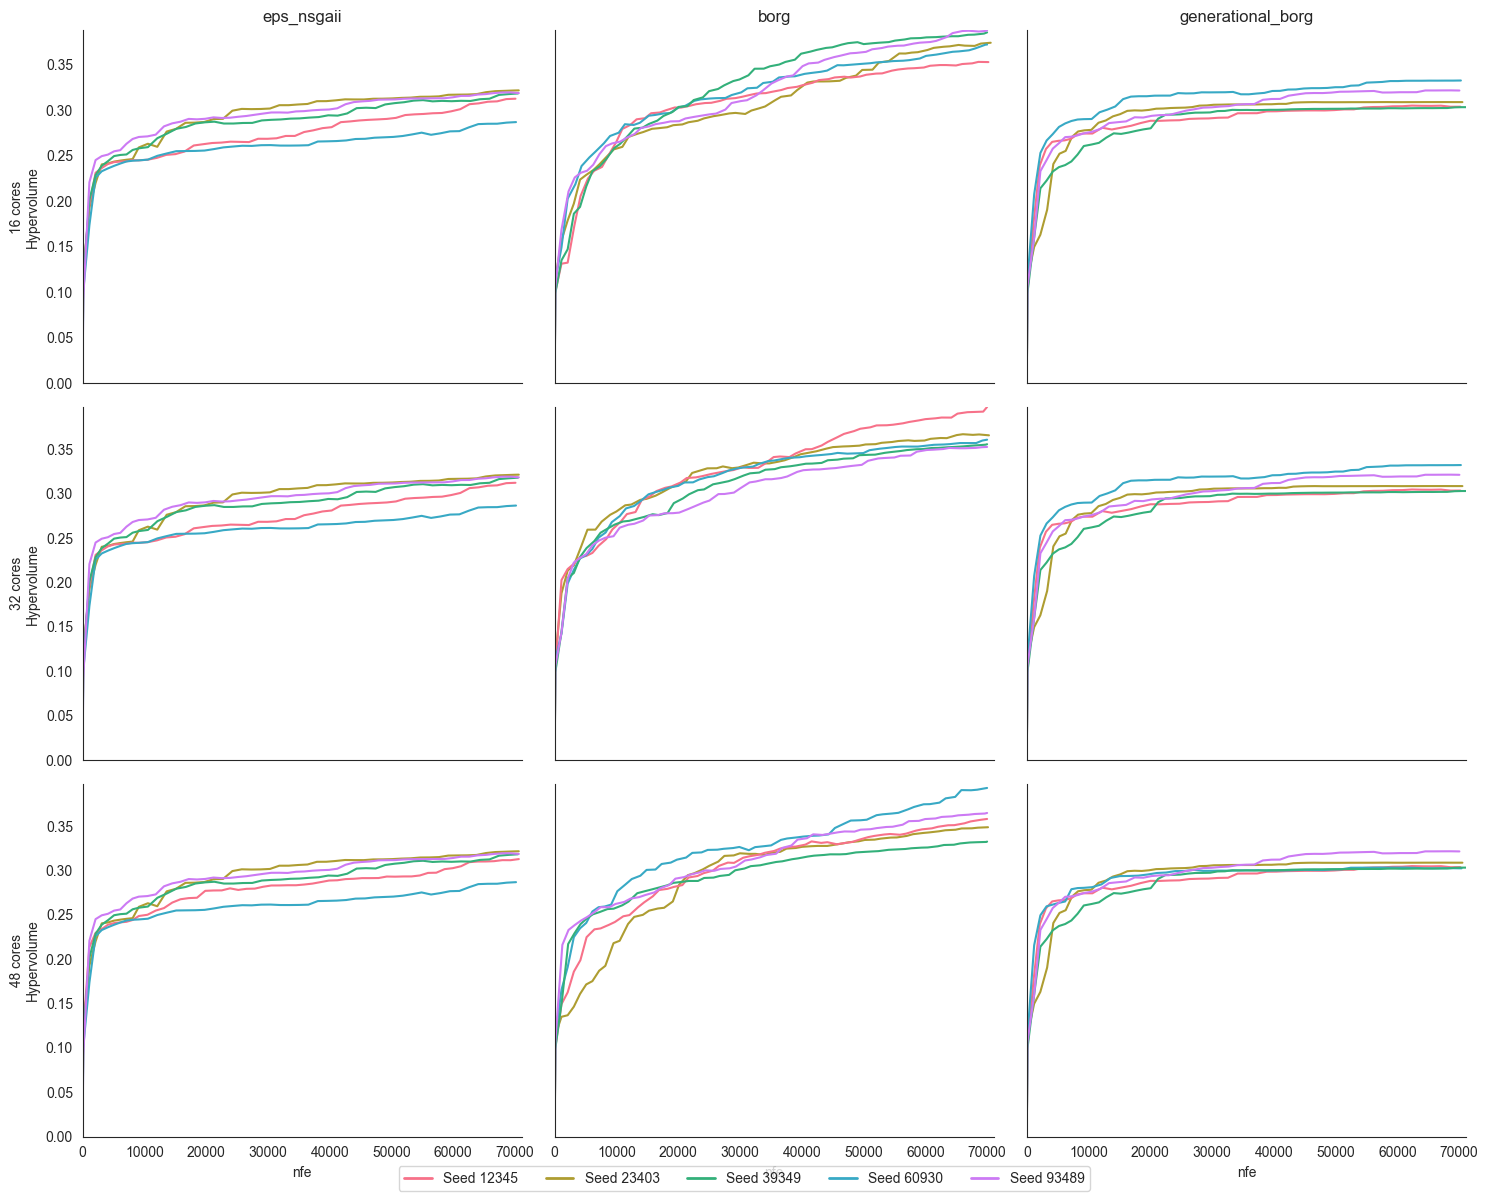

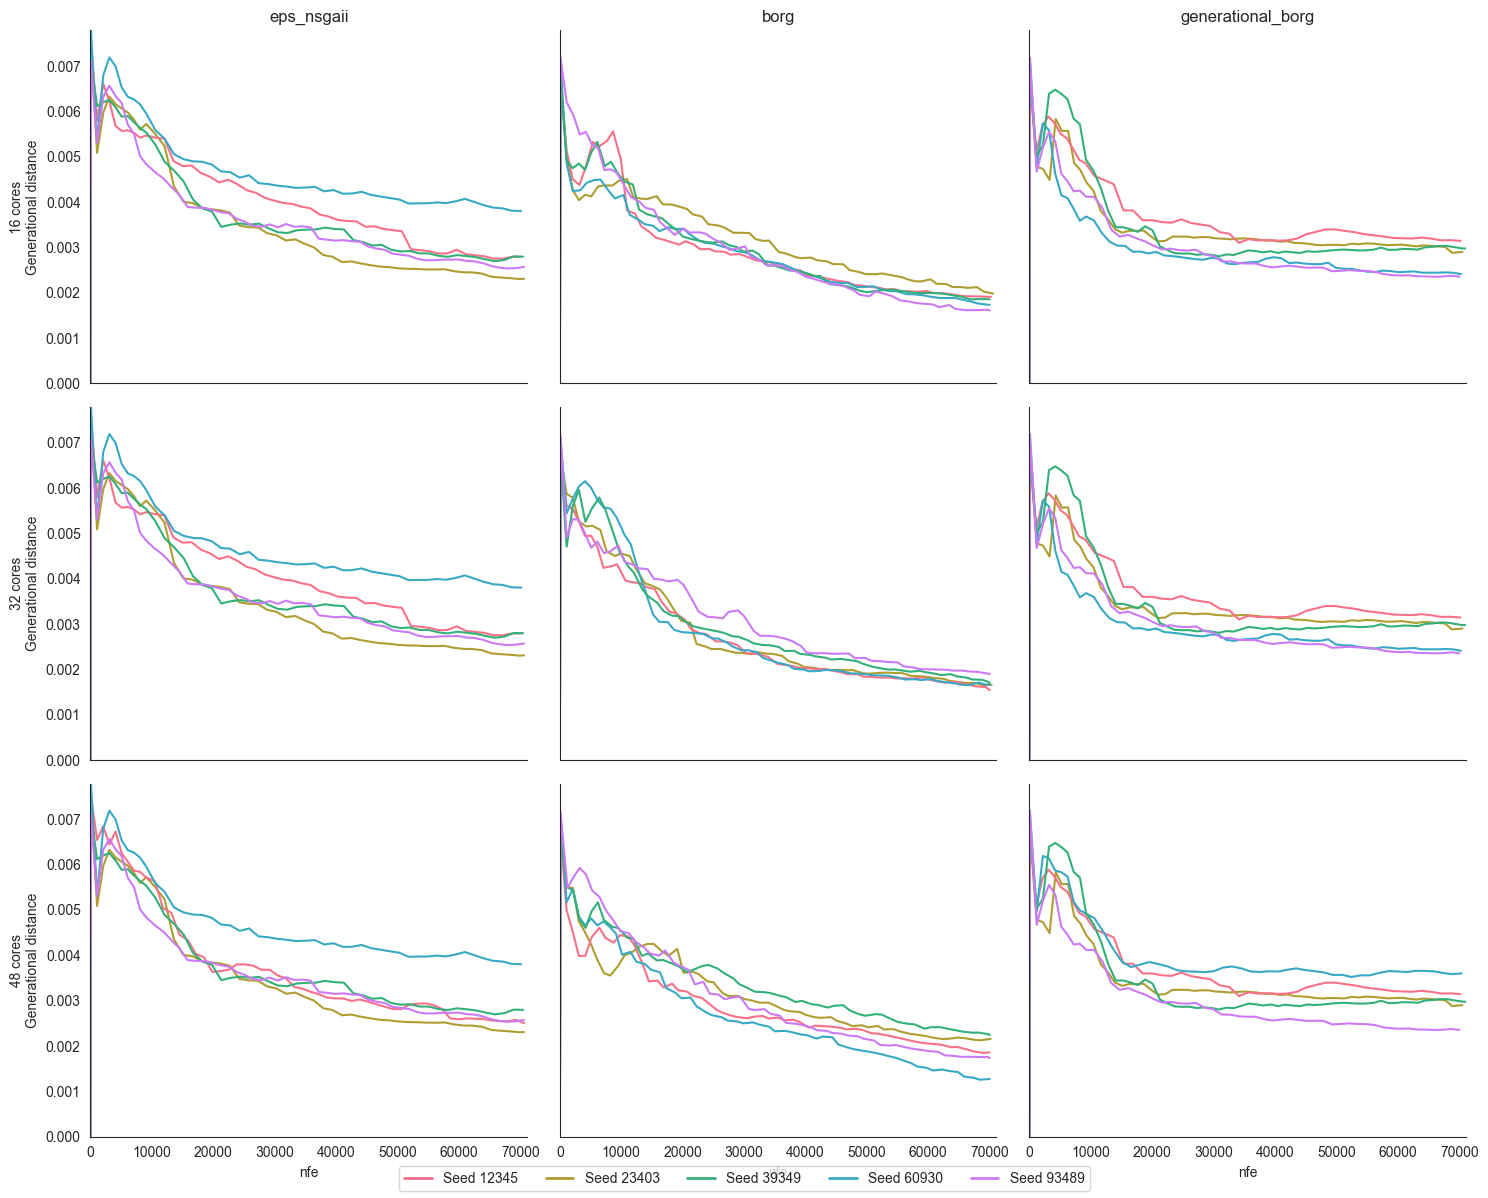

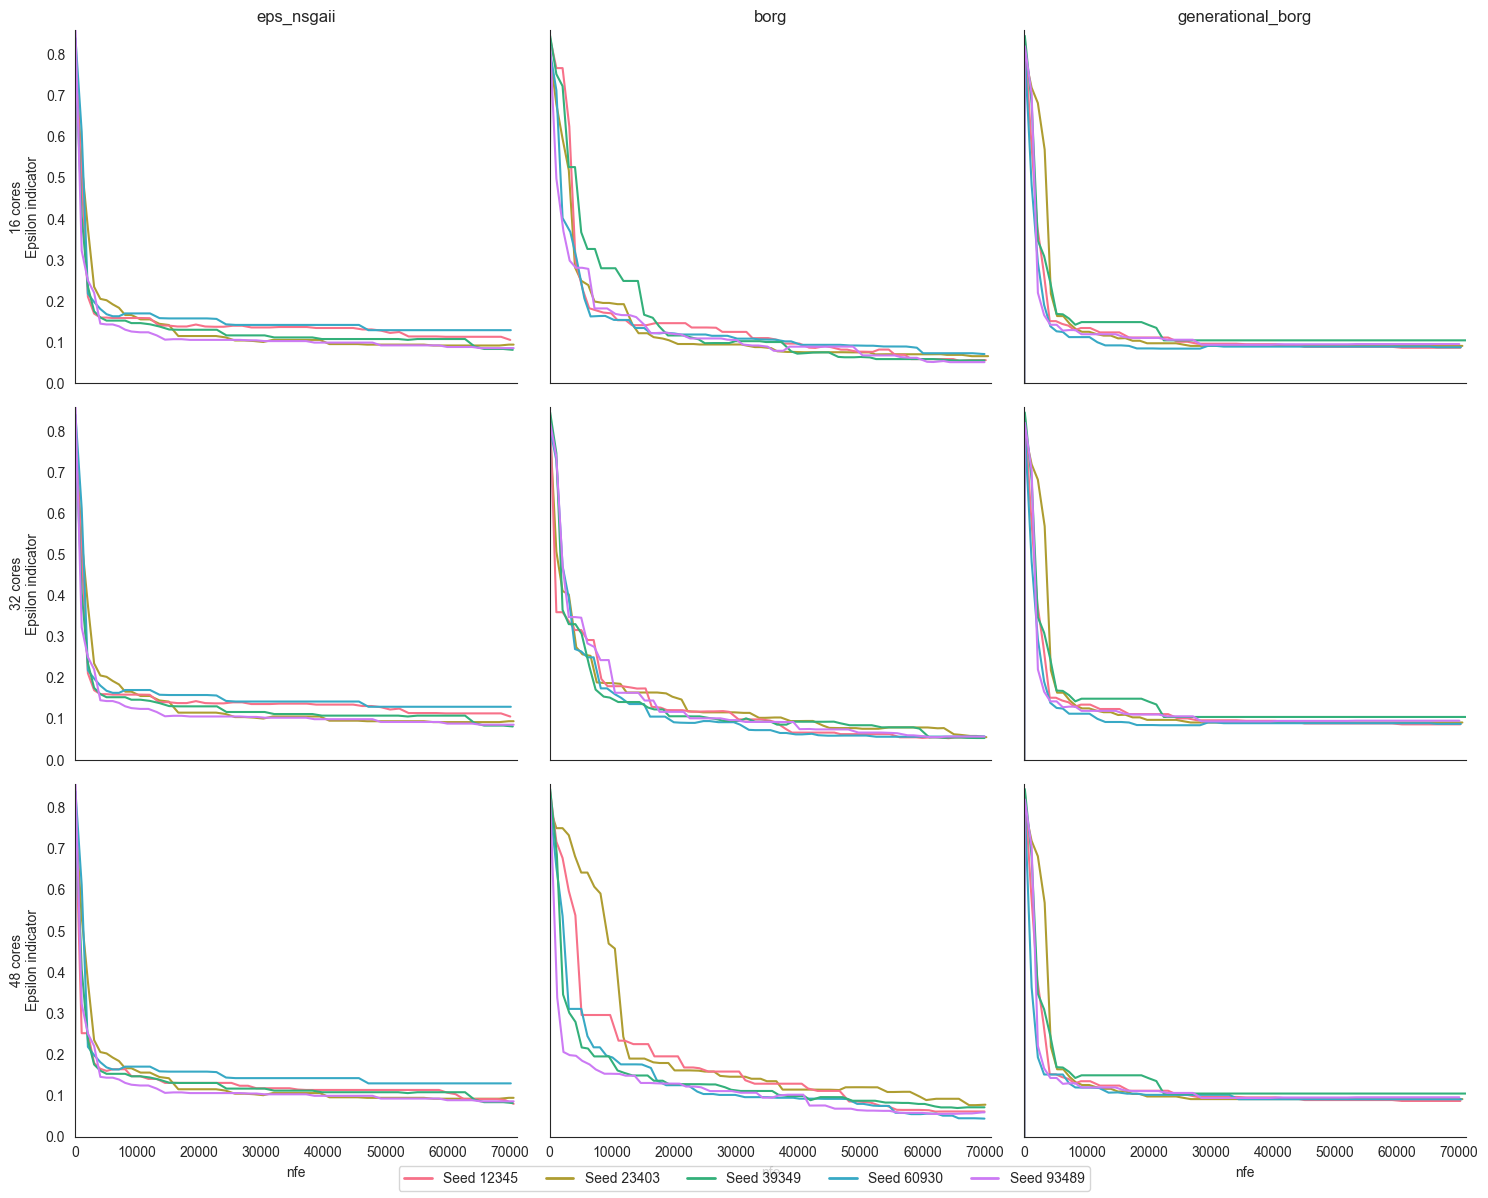

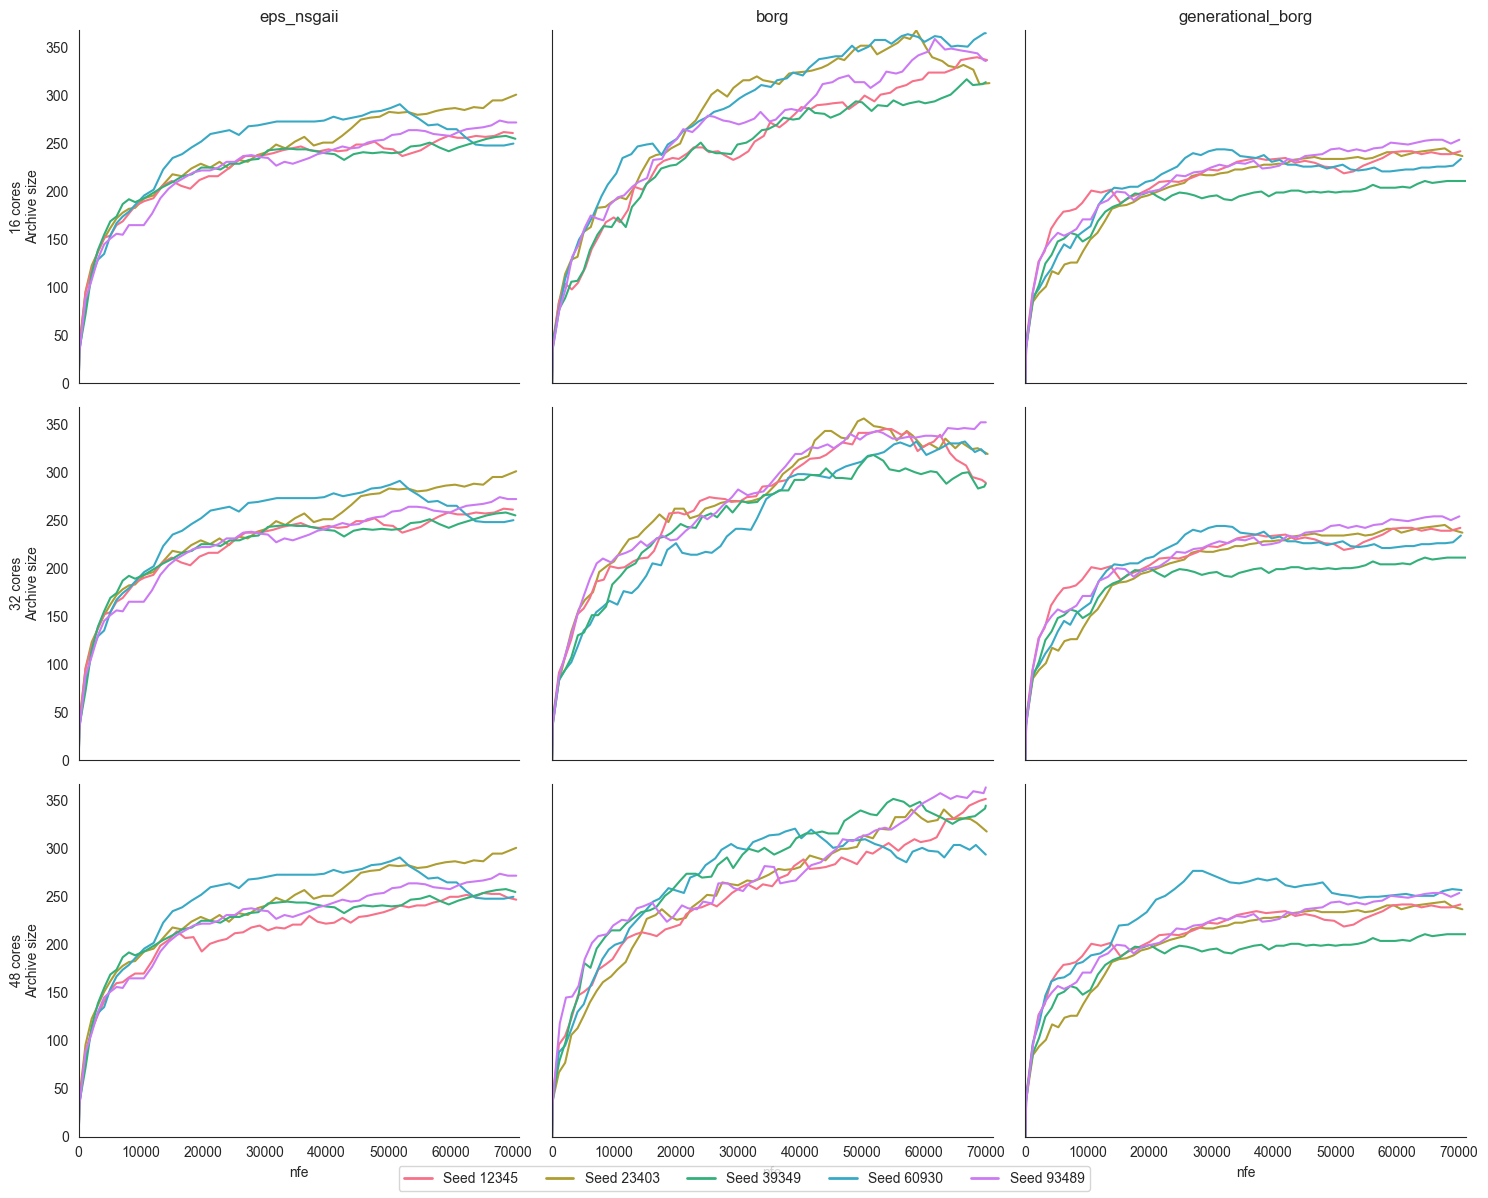

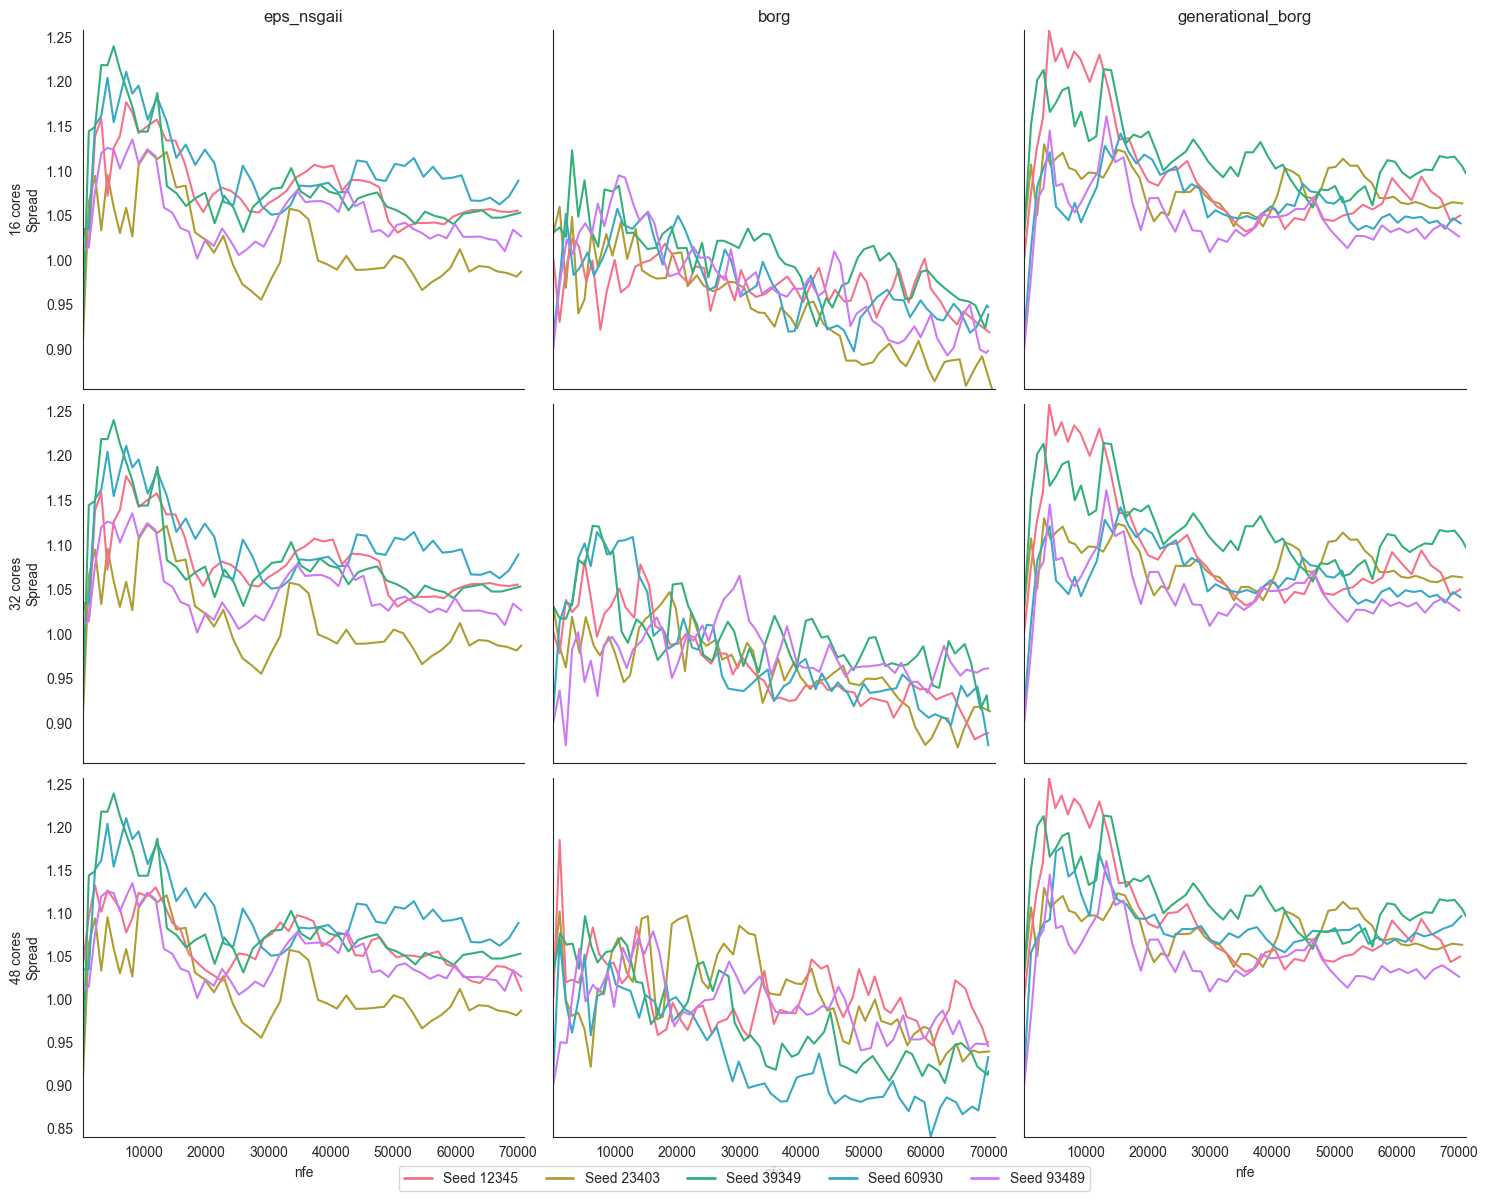

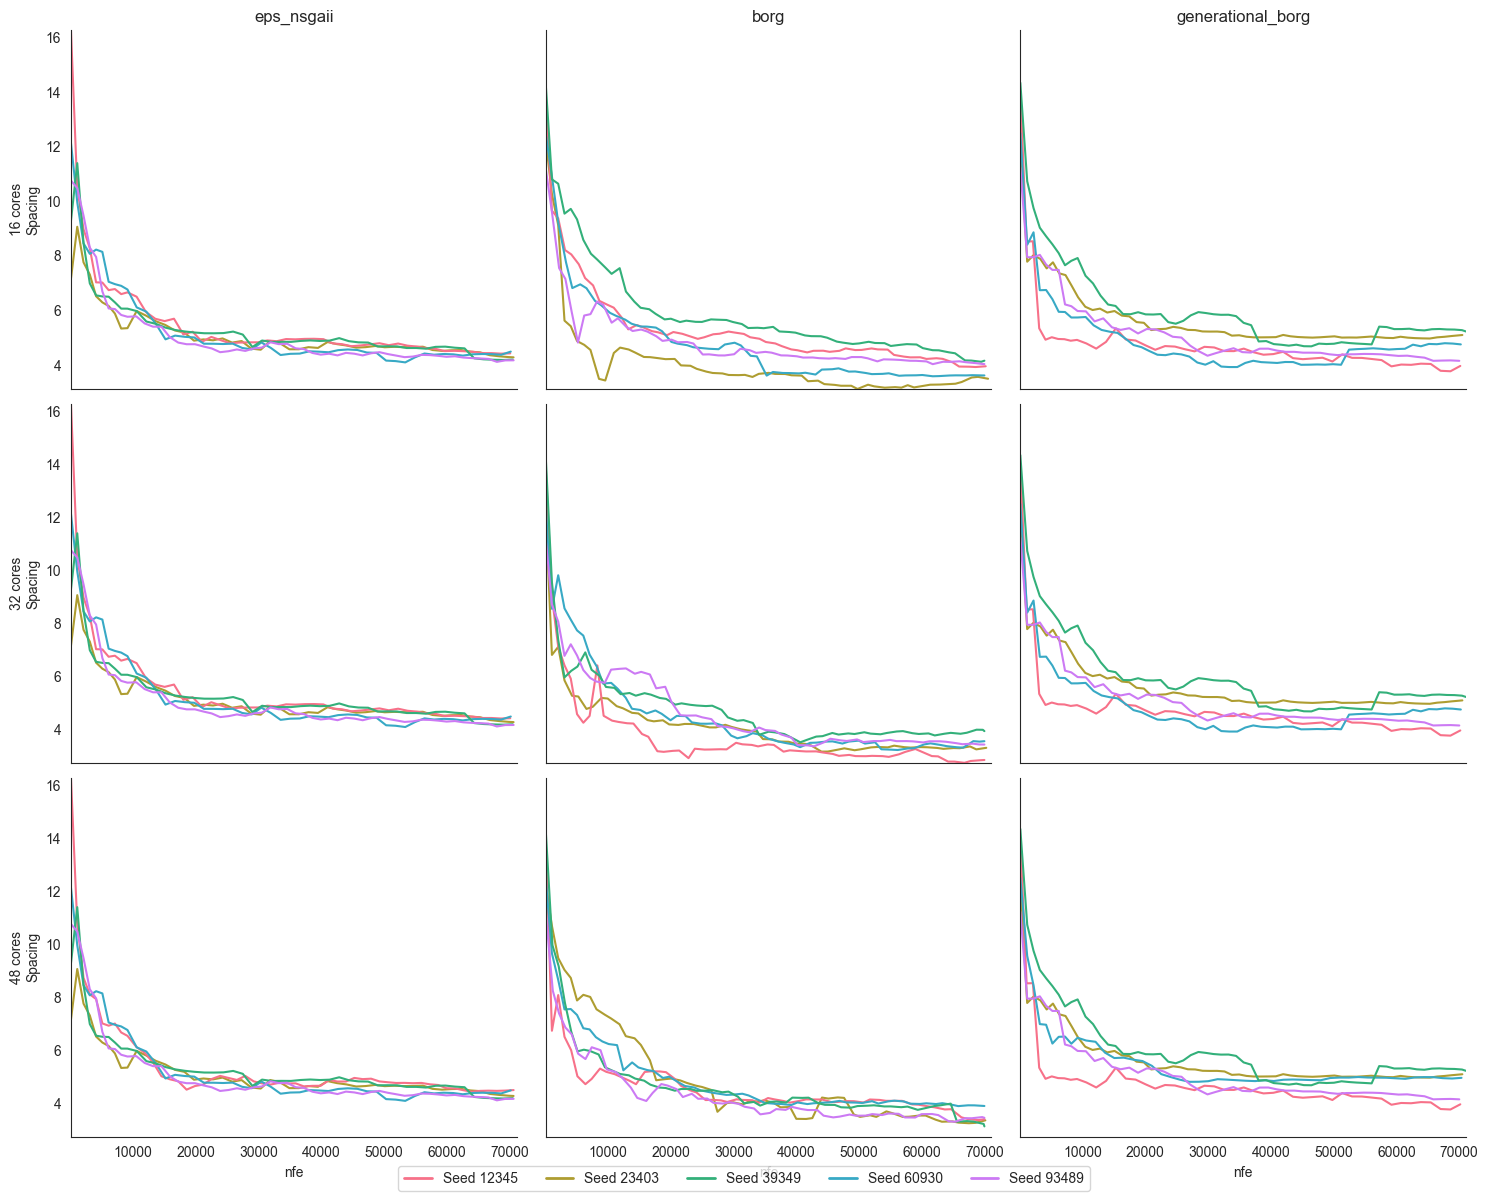

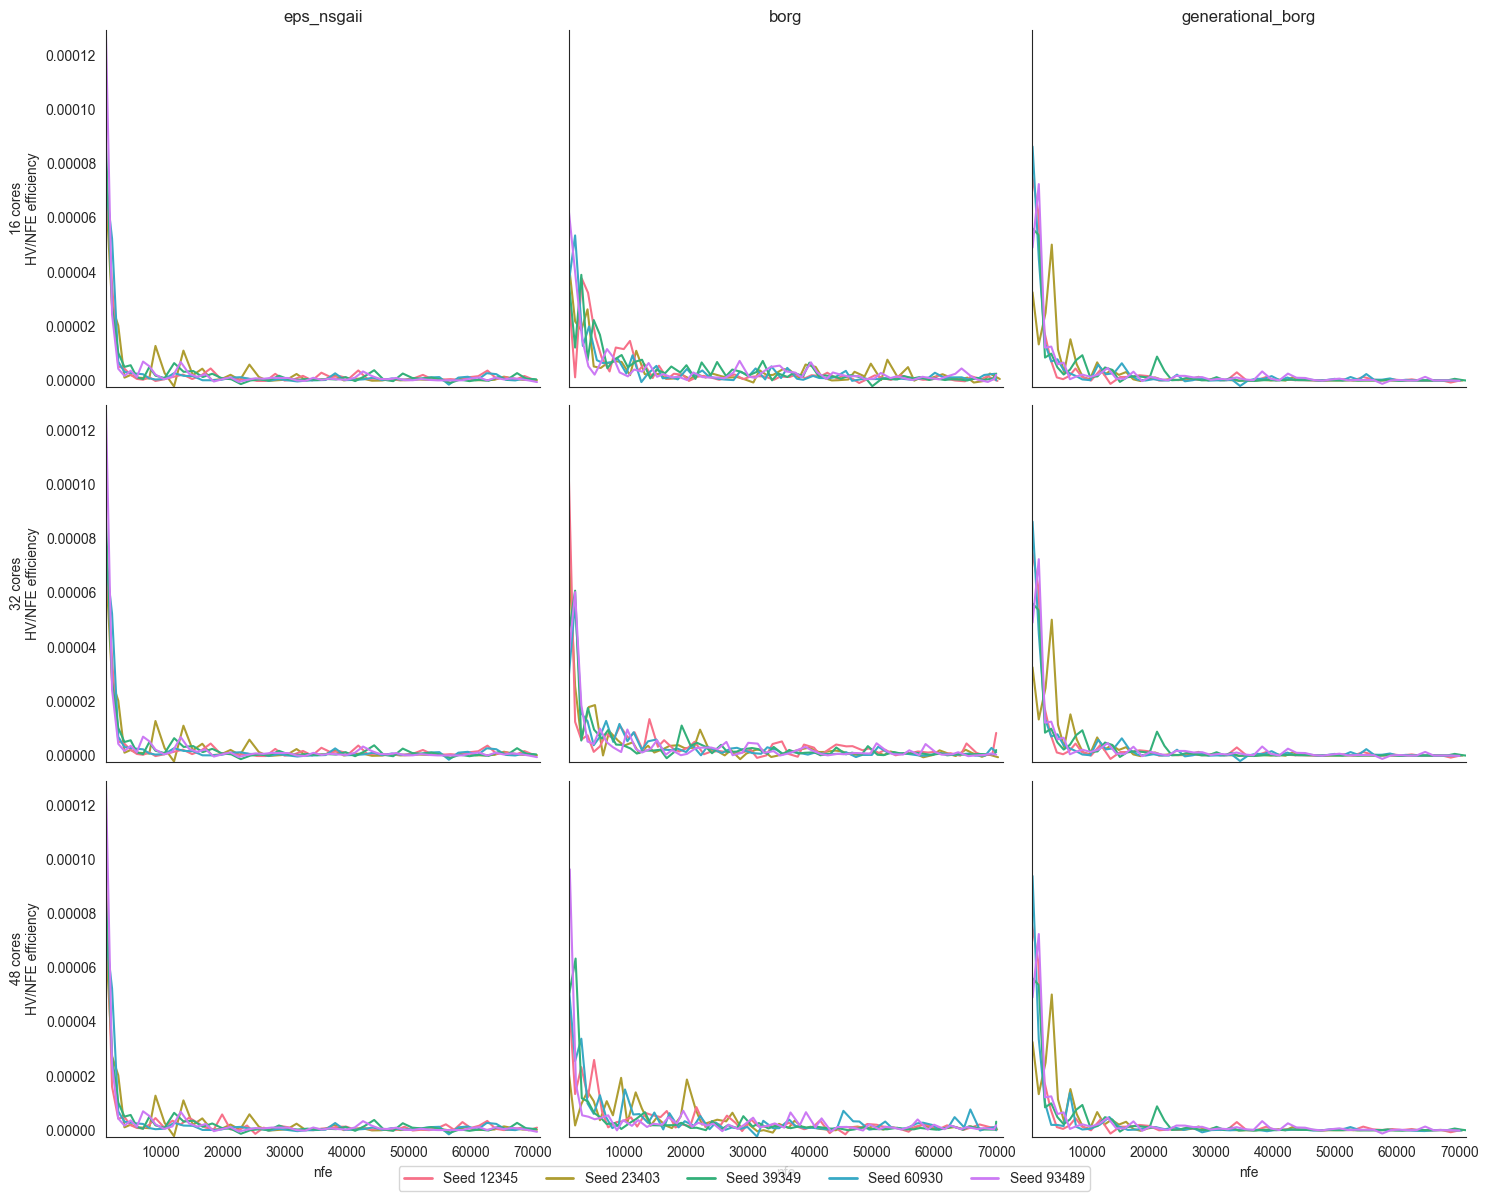

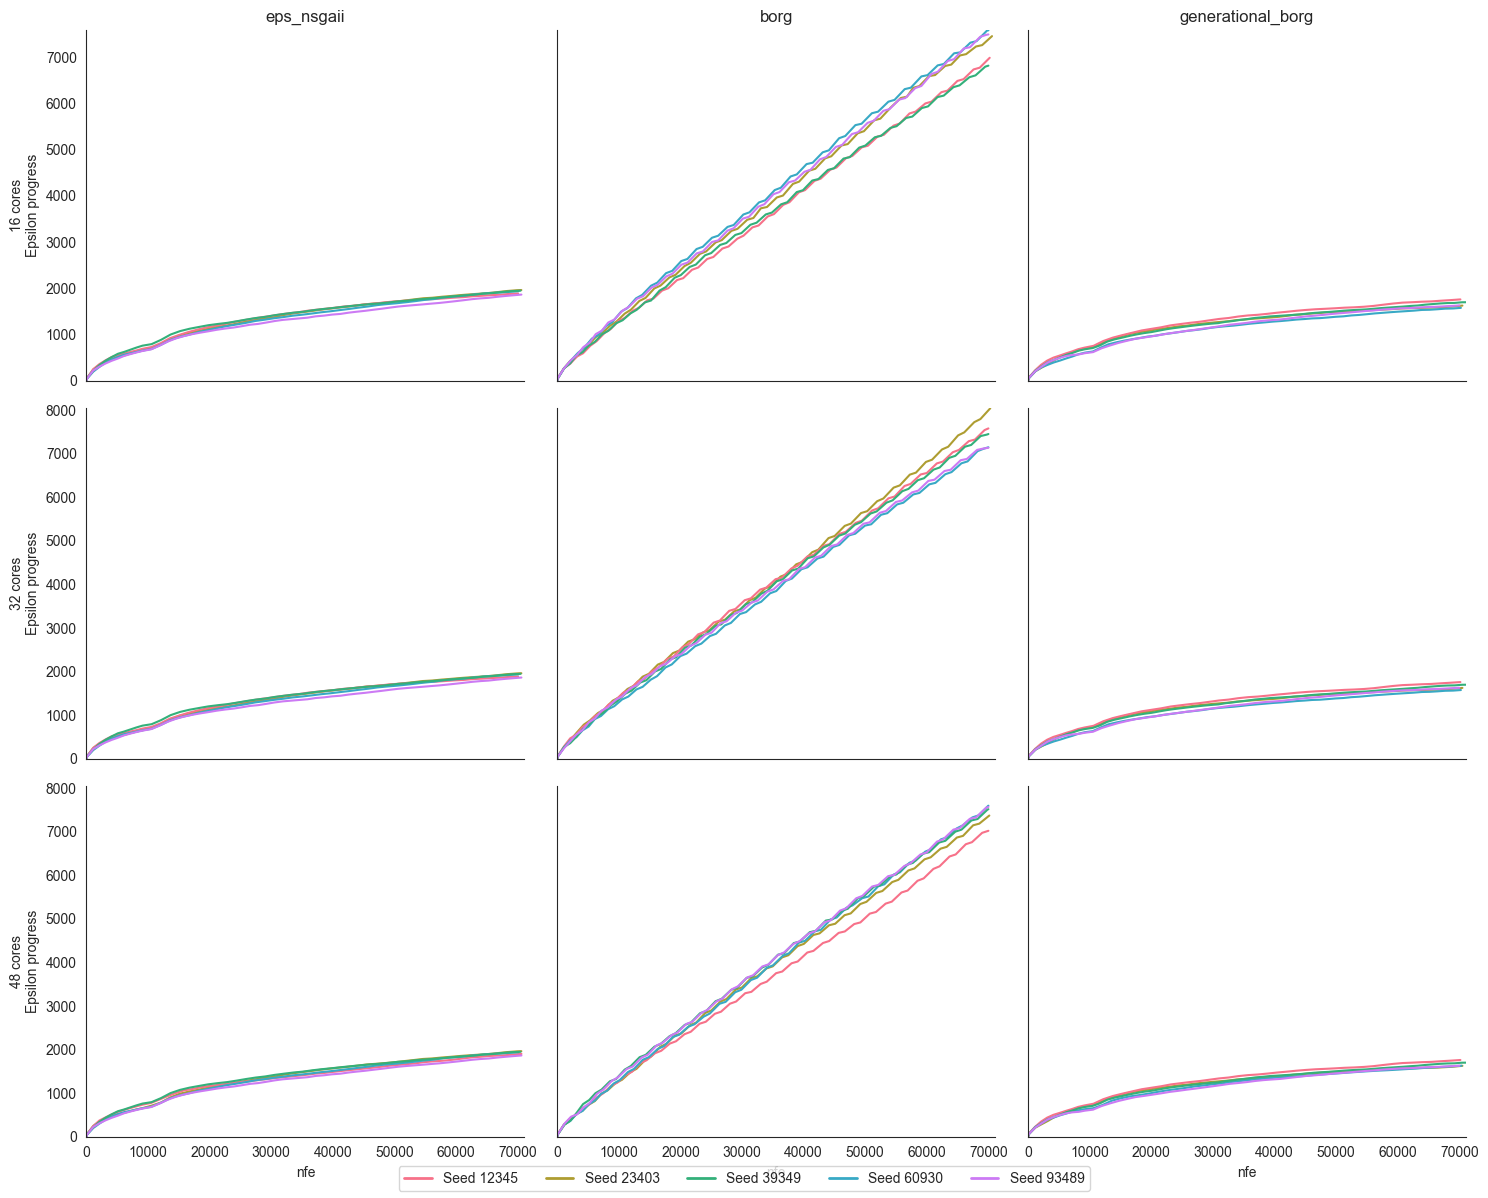

In [136]:
plot_metrics_by_cores(problem_names[2], moeas, core_count, metric_names)

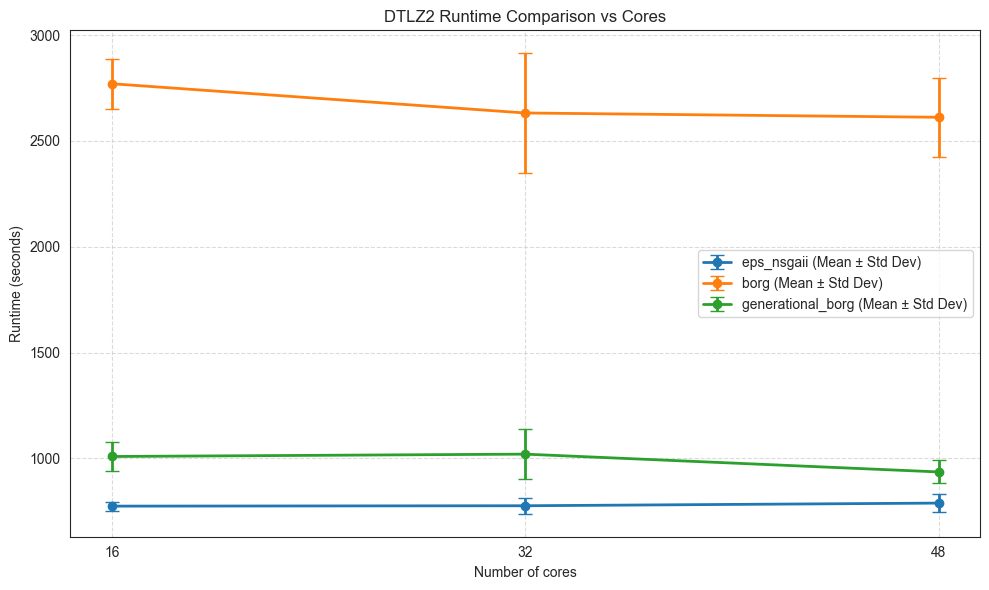

In [66]:
plot_runtime_comparison(problem_names[0], moeas, core_count)

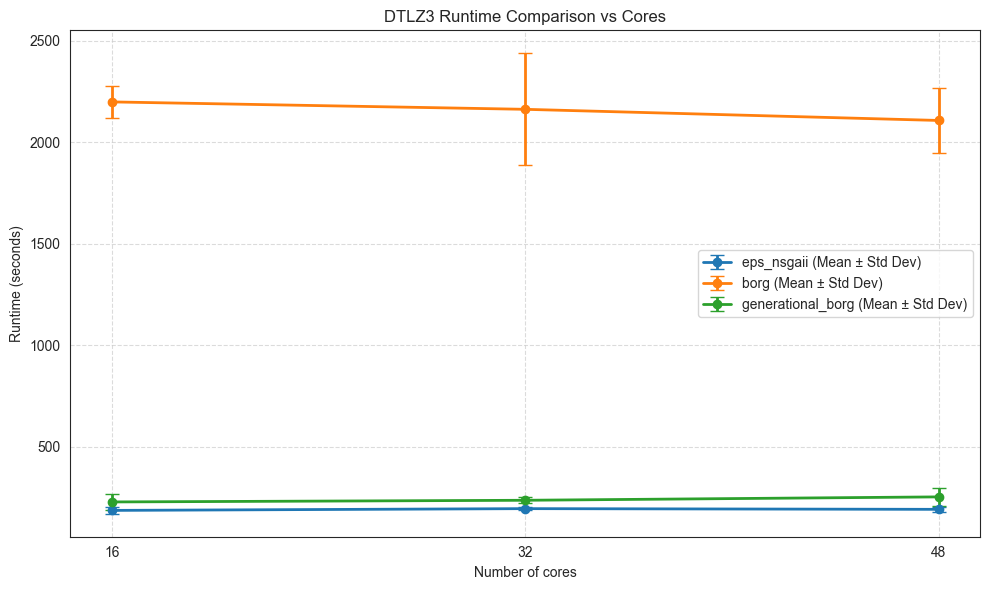

In [75]:
plot_runtime_comparison(problem_names[1], moeas, core_count)

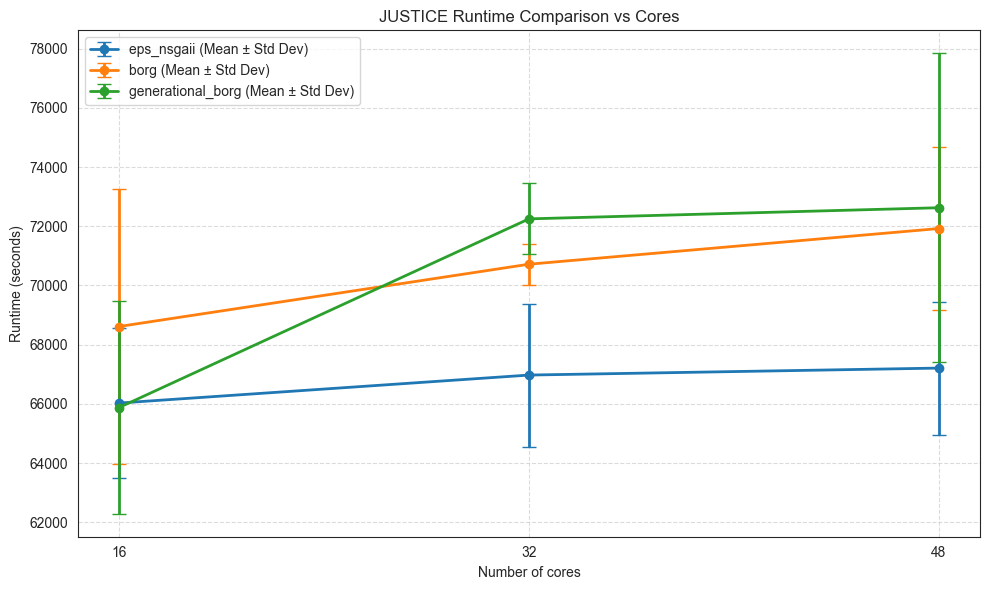

In [137]:
plot_runtime_comparison(problem_names[2], moeas, core_count)

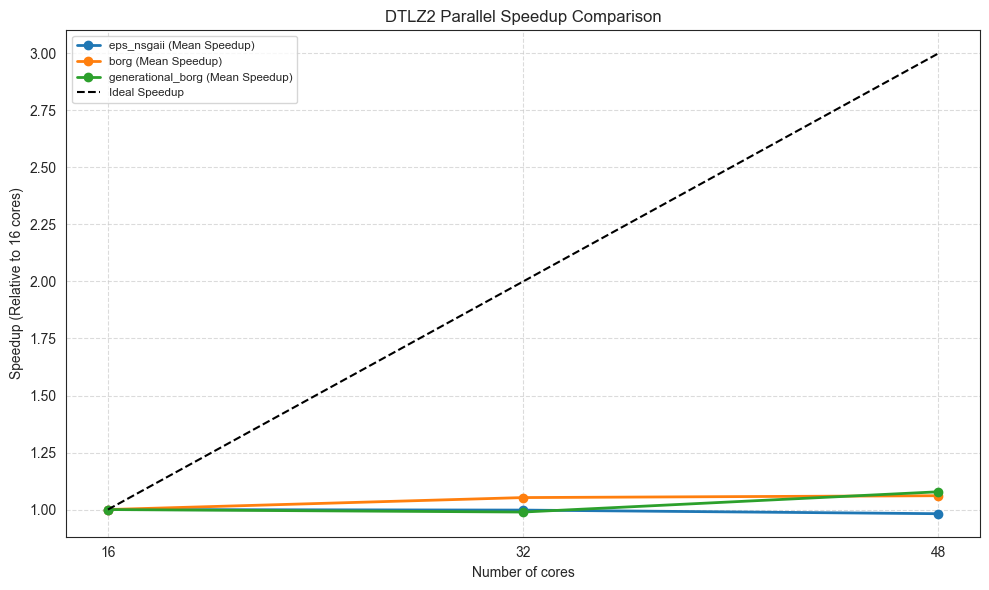

In [77]:
plot_speedup_comparison(problem_names[0], moeas, core_count)

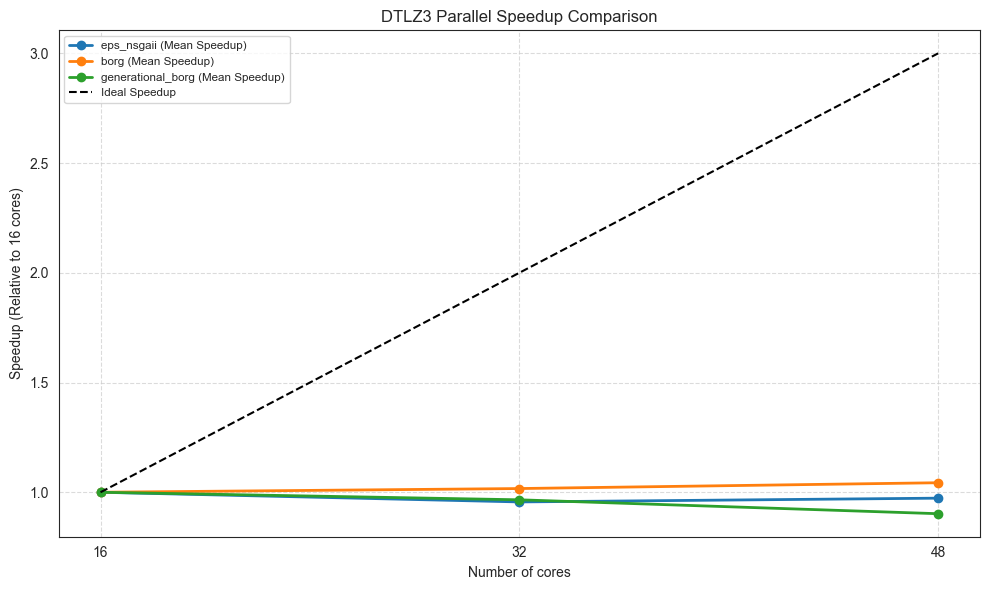

In [78]:
plot_speedup_comparison(problem_names[1], moeas, core_count)

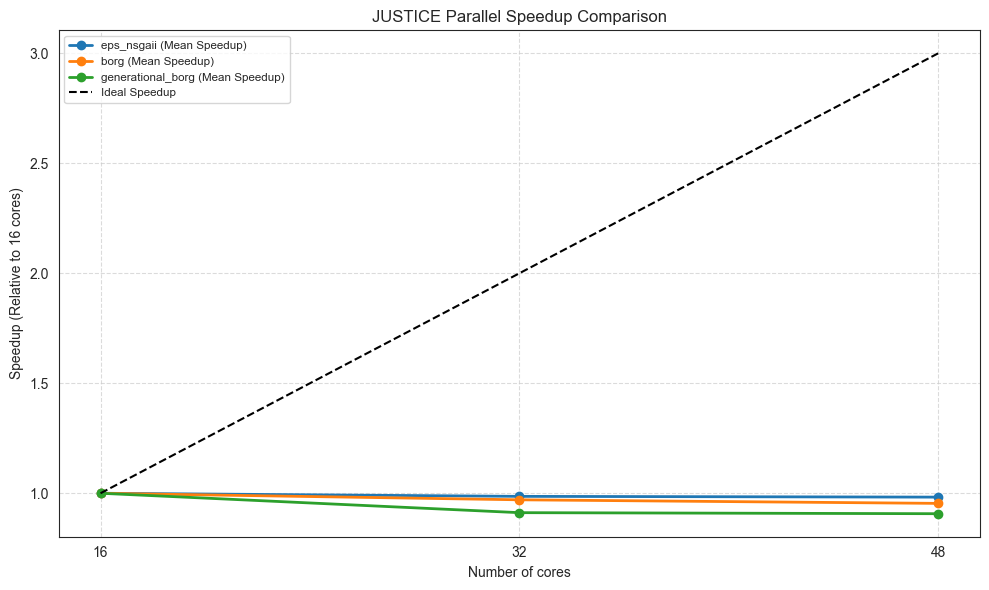

In [138]:
plot_speedup_comparison(problem_names[2], moeas, core_count)

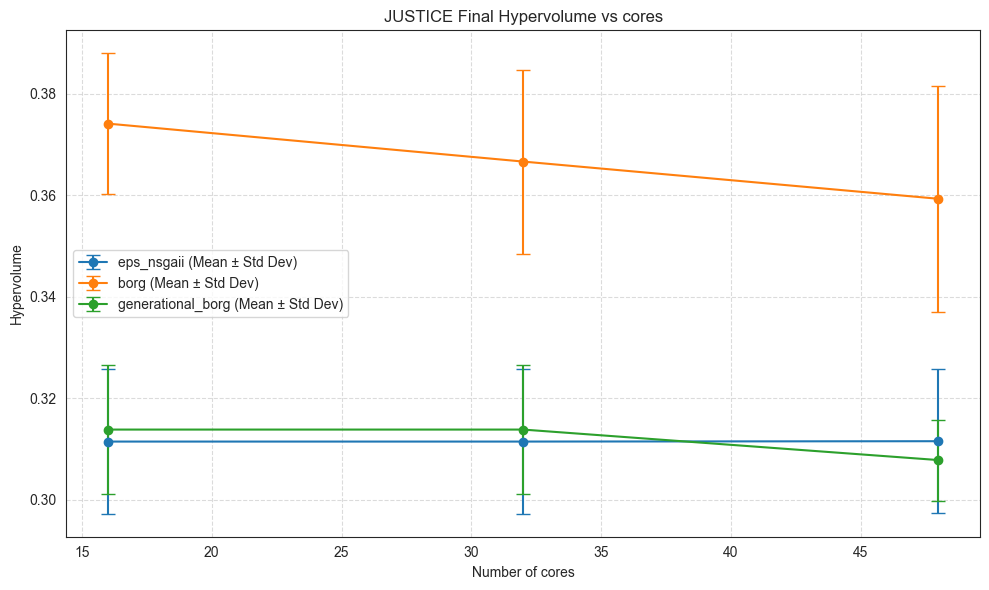

In [139]:
plot_final_metric_comparison(problem_names[2], moeas, core_count, 'hypervolume')

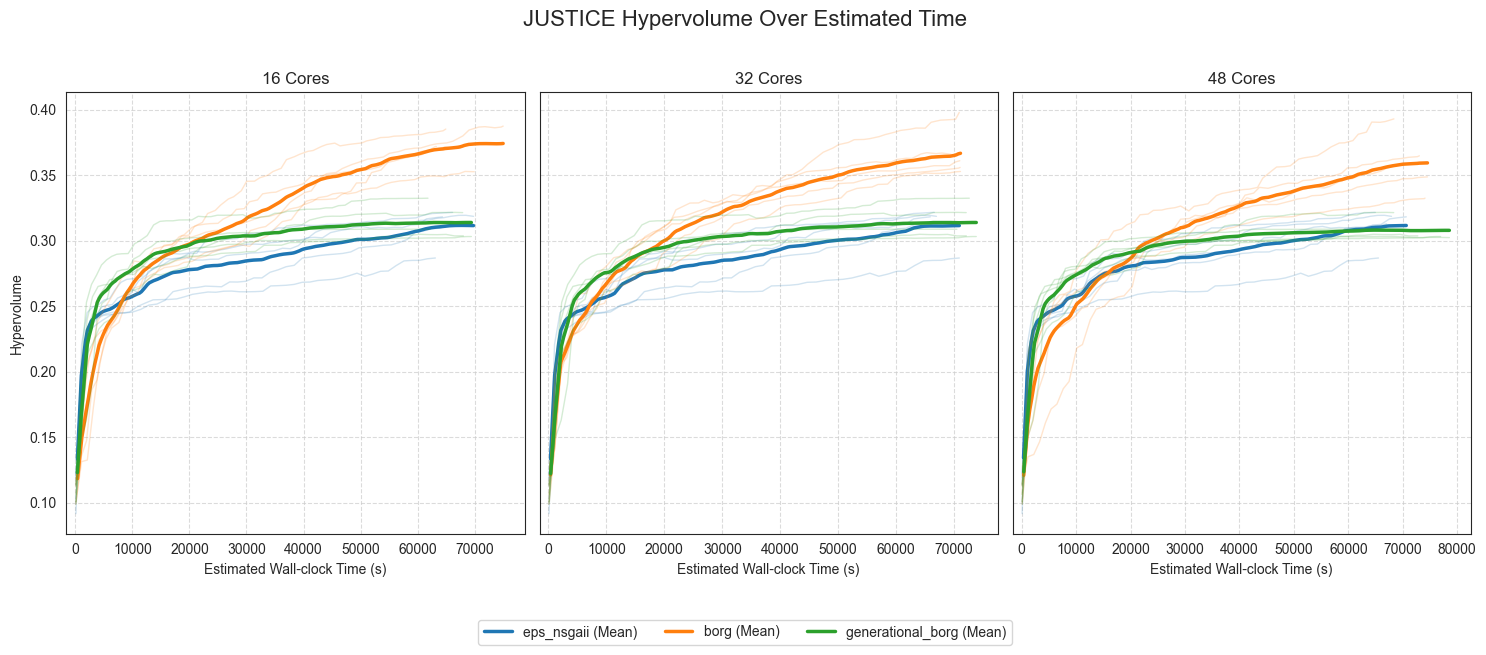

In [140]:
plot_hypervolume_over_time(problem_names[2], moeas, core_count)

**Quick objective value plotting**

In [ ]:
# Settings
justice_root = "./hdf5_results/JUSTICE"
core_counts = [16, 32, 48]
moeas = ["eps_nsgaii", "borg", "generational_borg"]
seeds = ["seed12345", "seed23403", "seed39349", "seed60930", "seed93489"]
epsilons = [0.01, 0.25, 10, 10]
model = get_justice_model()
problem = to_problem(model, searchover="levers")

# Final Pareto fronts storage
final_pareto_fronts = {}

# Loop over all combinations to create a big unified set per MOEA
for moea in moeas:
    # Container for DataFrames
    df_list = []    
    for cores in core_counts:
        for seed in seeds:
            h5_path = os.path.join(justice_root, f"{cores}cores", moea, seed, f"final_state_JUSTICE_{moea}_{cores}cores_{seed}.h5")
            if os.path.exists(h5_path):
                with h5py.File(h5_path, "r") as f:
                    results_group = f["final_archive"]
                    data = {key: results_group[key][()] for key in results_group}
                    df = pd.DataFrame(data)
                    df_list.append(df)
            else:
                print(f"File not found: {h5_path}")   
    pareto_front_df = epsilon_nondominated(df_list, epsilons, problem)
    final_pareto_fronts[moea] = pareto_front_df
    print(f"Found {len(pareto_front_df)} non-dominated solutions for {moea}.")

Found 336 non-dominated solutions for eps_nsgaii.
Found 351 non-dominated solutions for borg.
Found 287 non-dominated solutions for generational_borg.


In [29]:
def plot_final_aggregated_fronts_2d(fronts_dict, objectives_to_plot):
    """
    Generates a 2D scatter plot of the final, aggregated Pareto fronts.
    """
    obj1, obj2 = objectives_to_plot
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 9))

    # Define visual styles for each MOEA for a clear and professional plot
    styles = {
        'borg': {'color': '#1f77b4', 'marker': 'o', 'label': 'borg'},
        'eps_nsgaii': {'color': '#ff7f0e', 'marker': 's', 'label': 'eps_nsgaii'},
        'generational_borg': {'color': '#2ca02c', 'marker': '^', 'label': 'generational_borg'}
    }

    for moea, front_df in fronts_dict.items():
        if front_df.empty:
            continue
        
        style = styles.get(moea, {})
        ax.scatter(front_df[obj1], front_df[obj2],
                   alpha=0.7, s=50,  # s is marker size
                   label=style.get('label'),
                   color=style.get('color'),
                   marker=style.get('marker'),
                   edgecolors='black', linewidth=0.5)

    ax.set_title(f'Aggregated Pareto Fronts showing {objectives_to_plot[0]} and {objectives_to_plot[1]}', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel(obj1.replace('_', ' ').title(), fontsize=14)
    ax.set_ylabel(obj2.replace('_', ' ').title(), fontsize=14)
    
    legend = ax.legend(fontsize=12, title_fontsize=13)
    legend.get_frame().set_edgecolor('black')

    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    fig.savefig(f'figures/{objectives_to_plot[0]}_{objectives_to_plot[1]}_final_aggregated_fronts.png', dpi=300, bbox_inches='tight')


In [26]:
def plot_final_aggregated_fronts_3d(fronts_dict, objectives_to_plot):
    """
    Generates a 3D scatter plot of the final, aggregated Pareto fronts for three objectives.
    """

    obj1, obj2, obj3 = objectives_to_plot
    
    plt.style.use('seaborn-v0_8-whitegrid')
    # Create a figure and a 3D subplot
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')

    styles = {
        'borg': {'color': '#1f77b4', 'marker': 'o', 'label': 'Borg'},
        'eps_nsgaii': {'color': '#ff7f0e', 'marker': 's', 'label': 'ϵ-NSGA-II'},
        'generational_borg': {'color': '#2ca02c', 'marker': '^', 'label': 'Generational Borg'}
    }

    for moea, front_df in fronts_dict.items():
        if front_df.empty:
            continue
        
        style = styles.get(moea, {})
        # The scatter function for 3D plots takes xs, ys, and zs as the first three arguments
        ax.scatter(front_df[obj1], front_df[obj2], front_df[obj3],
                   alpha=0.7, s=50,  # s is marker size
                   label=style.get('label'),
                   color=style.get('color'),
                   marker=style.get('marker'),
                   edgecolors='black', linewidth=0.5)

    ax.set_title(f'Aggregated Pareto Fronts (3D)', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel(obj1.replace('_', ' ').title(), fontsize=12, labelpad=10)
    ax.set_ylabel(obj2.replace('_', ' ').title(), fontsize=12, labelpad=10)
    ax.set_zlabel(obj3.replace('_', ' ').title(), fontsize=12, labelpad=10)
    
    legend = ax.legend(fontsize=12, title_fontsize=13)
    legend.get_frame().set_edgecolor('black')

    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Adjust the viewing angle for better presentation
    ax.view_init(elev=20., azim=-65)
    
    plt.tight_layout()
    fig.savefig(f'figures/{obj1}_{obj2}_{obj3}_final_3d_fronts.png', dpi=300, bbox_inches='tight')
    plt.show()



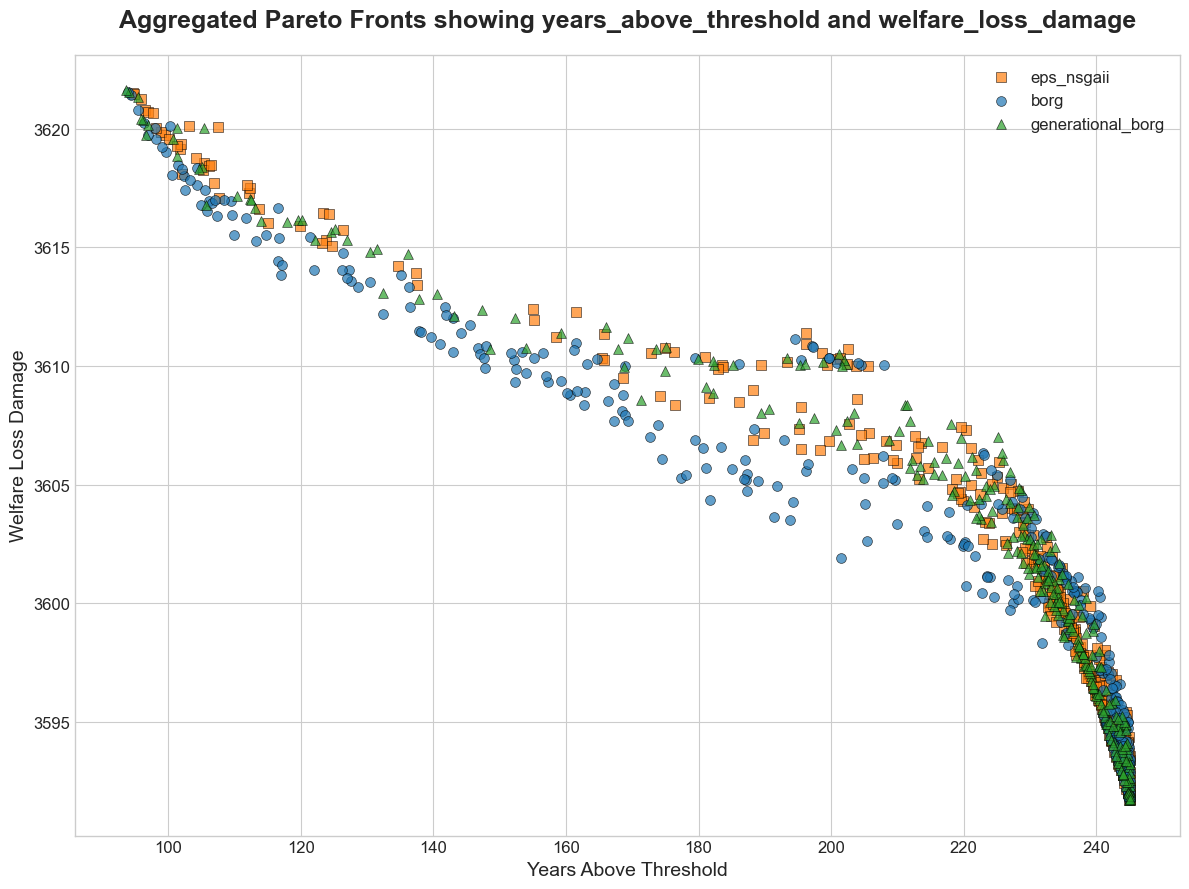

In [34]:
plot_final_aggregated_fronts_2d(final_pareto_fronts, ['years_above_threshold', 'welfare_loss_damage'])

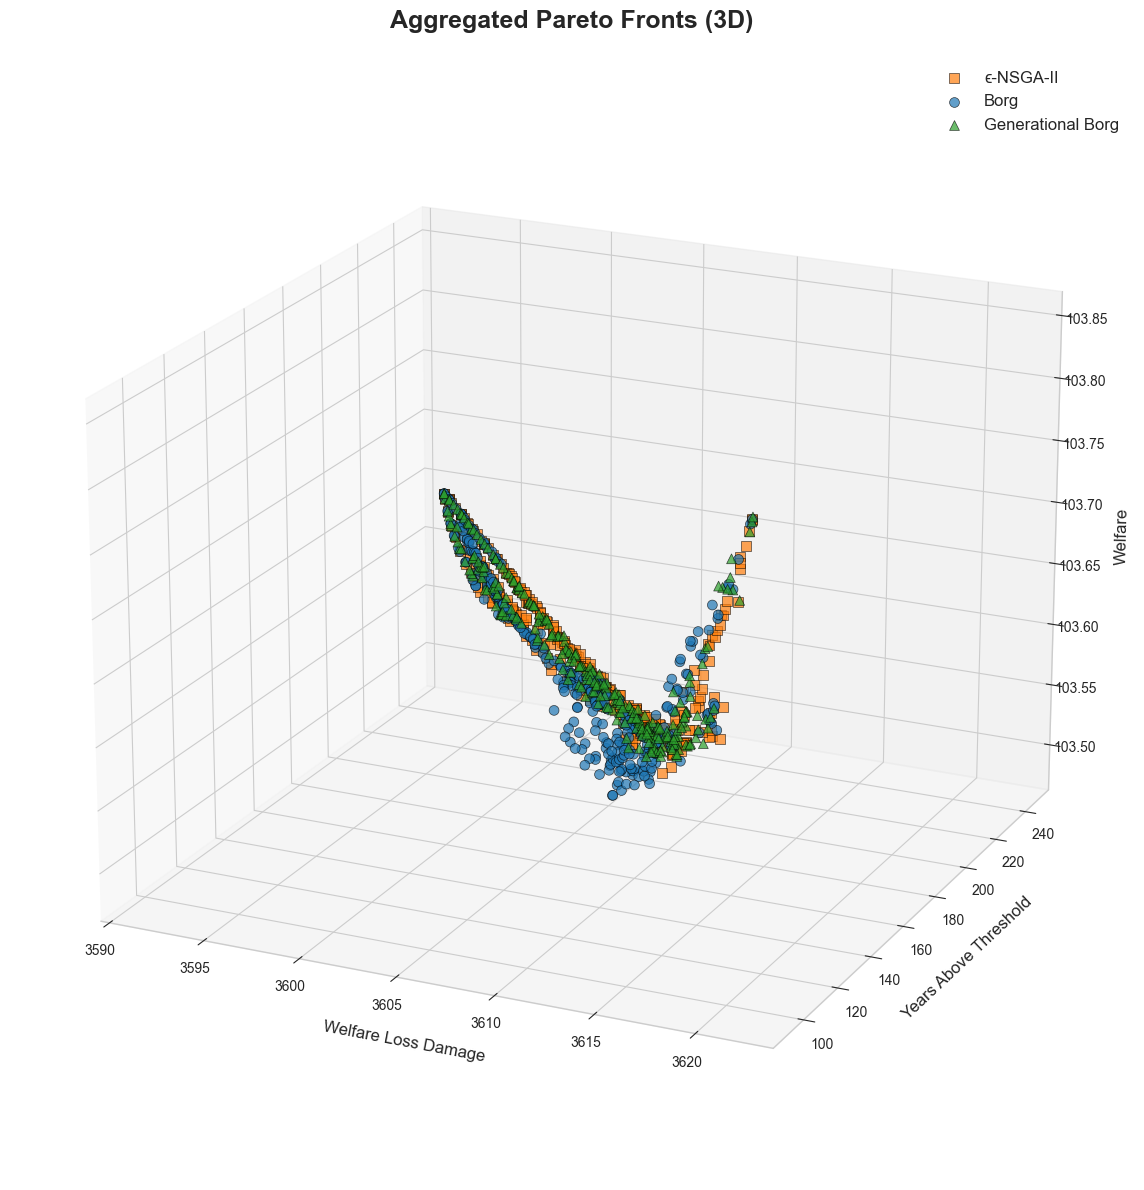

In [27]:
plot_final_aggregated_fronts_3d(final_pareto_fronts, ['welfare_loss_damage', 'years_above_threshold', 'welfare'])